# CatTSunami Tutorial

In [41]:
from fairchem.applications.cattsunami.core import Reaction
from fairchem.data.oc.core import Slab, Adsorbate, Bulk, AdsorbateSlabConfig
from fairchem.core.common.relaxation.ase_utils import OCPCalculator
from ase.optimize import BFGS
from x3dase.visualize import view_x3d_n
from ase.io import read
from x3dase.x3d import X3D
from fairchem.applications.cattsunami.databases import DISSOCIATION_REACTION_DB_PATH
from fairchem.data.oc.databases.pkls import ADSORBATE_PKL_PATH, BULK_PKL_PATH
from fairchem.core.models.model_registry import model_name_to_local_file
import matplotlib.pyplot as plt
from fairchem.applications.cattsunami.core.autoframe import AutoFrameDissociation
from fairchem.applications.cattsunami.core import OCPNEB
from ase.io import read

#Optional
from IPython.display import Image
from x3dase.x3d import X3D

#Set random seed
import numpy as np
np.random.seed(22)

In [42]:
# from ase.build import molecule
# import pickle 
# adsorbates = pickle.load(open(ADSORBATE_PKL_PATH, "rb"))
# adsorbates[86] = (molecule("O2"), '*O2', np.array([0]),'O<sub>2(g)</sub> + * &rarr; *O2')
# # dump the updated pickle 
# pickle.dump(adsorbates, open("updated_adsorbates.pkl", "wb"))

In [43]:
# rxns = pickle.load(open(DISSOCIATION_REACTION_DB_PATH, "rb"))
# rxns.append(
#     {
#  'reaction': '*O2 -> *O + *O',
#  'reaction_type': 'dissociation',
#  'reactant': 86,
#  'product1': 0,
#  'product2': 0,
#  'idx_mapping': [{0: 1, 1: 0}, {0: 0, 1: 1}],
#  'edge_indices_initial': [(0, 1)],
#  'edge_indices_final': []
# }
# )
# # dump the updated pickle 
# pickle.dump(rxns, open("updated_reactions.pkl", "wb"))

## Do enumerations in an AdsorbML style

In [44]:
ADSORBATE_PKL_PATH = "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/updated_adsorbates.pkl"
DISSOCIATION_REACTION_DB_PATH =  "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/updated_reactions.pkl"

In [45]:
# Instantiate the reaction class for the reaction of interest
reaction = Reaction(reaction_str_from_db="*O2 -> *O + *O",
                    reaction_db_path=DISSOCIATION_REACTION_DB_PATH,
                    adsorbate_db_path = ADSORBATE_PKL_PATH)

In [46]:
# Instantiate our adsorbate class for the reactant and product
reactant = Adsorbate(adsorbate_id_from_db=reaction.reactant1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH)
product1 = Adsorbate(adsorbate_id_from_db=reaction.product1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH)
product2 = Adsorbate(adsorbate_id_from_db=reaction.product2_idx, adsorbate_db_path=ADSORBATE_PKL_PATH)

In [47]:
# Grab the bulk and cut the slab we are interested in
bulk = Bulk(bulk_src_id_from_db="mp-30", bulk_db_path=BULK_PKL_PATH)
slab = Slab.from_bulk_get_specific_millers(bulk = bulk, specific_millers=(2,1,1))

In [48]:
# Perform site enumeration
# For AdsorbML num_sites = 100, but we use 3 here for brevity. This should be increased for practical use.
reactant_configs = AdsorbateSlabConfig(slab = slab[0], adsorbate = reactant,
                                       mode="random_site_heuristic_placement",
                                       num_sites = 100).atoms_list
product1_configs = AdsorbateSlabConfig(slab = slab[0], adsorbate = product1,
                                      mode="random_site_heuristic_placement",
                                      num_sites = 100).atoms_list
product2_configs = AdsorbateSlabConfig(slab = slab[0], adsorbate = product2,
                                      mode="random_site_heuristic_placement",
                                      num_sites = 100).atoms_list

In [49]:
# Instantiate the calculator
# NOTE: If you have a GPU, use cpu = False
# NOTE: Change the checkpoint path to locally downloaded files as needed
checkpoint_path = model_name_to_local_file('EquiformerV2-31M-S2EF-OC20-All+MD', local_cache='/tmp/ocp_checkpoints/')
cpu = False
calc = OCPCalculator(checkpoint_path = checkpoint_path, cpu = cpu)

In [50]:
# Relax the reactant systems
reactant_energies = []
for config in reactant_configs:
    config.calc = calc
    opt = BFGS(config)
    opt.run(fmax = 0.05, steps=200)
    reactant_energies.append(config.get_potential_energy())

      Step     Time          Energy         fmax
BFGS:    0 15:02:12        5.015625        3.1125
BFGS:    1 15:02:12        4.960938        1.2832
BFGS:    2 15:02:12        4.890625        0.8406
BFGS:    3 15:02:12        4.714844        1.6712
BFGS:    4 15:02:12        4.648438        1.1887
BFGS:    5 15:02:12        4.640625        0.3942
BFGS:    6 15:02:12        4.632812        0.3318
BFGS:    7 15:02:12        4.644531        0.5749
BFGS:    8 15:02:13        4.640625        0.5720
BFGS:    9 15:02:13        4.632812        0.3553
BFGS:   10 15:02:13        4.625000        0.2159
BFGS:   11 15:02:13        4.625000        0.4034
BFGS:   12 15:02:13        4.613281        0.5471
BFGS:   13 15:02:13        4.613281        0.3987
BFGS:   14 15:02:13        4.613281        0.2348
BFGS:   15 15:02:13        4.609375        0.1248
BFGS:   16 15:02:13        4.613281        0.1586
BFGS:   17 15:02:13        4.617188        0.2098
BFGS:   18 15:02:14        4.609375        0.2226
B

BFGS:    4 15:02:28        4.691406        1.6677
BFGS:    5 15:02:28        4.664062        0.5597
BFGS:    6 15:02:28        4.644531        0.3360
BFGS:    7 15:02:28        4.648438        0.9411
BFGS:    8 15:02:28        4.632812        1.1883
BFGS:    9 15:02:28        4.597656        1.1106
BFGS:   10 15:02:29        4.566406        0.6207
BFGS:   11 15:02:29        4.539062        0.4355
BFGS:   12 15:02:29        4.531250        0.5762
BFGS:   13 15:02:29        4.511719        0.6410
BFGS:   14 15:02:29        4.496094        0.4119
BFGS:   15 15:02:29        4.492188        0.2236
BFGS:   16 15:02:29        4.488281        0.2590
BFGS:   17 15:02:29        4.488281        0.4288
BFGS:   18 15:02:29        4.468750        0.5335
BFGS:   19 15:02:29        4.453125        0.4462
BFGS:   20 15:02:30        4.449219        0.2371
BFGS:   21 15:02:30        4.445312        0.1800
BFGS:   22 15:02:30        4.441406        0.2048
BFGS:   23 15:02:30        4.437500        0.2733


BFGS:  135 15:02:45        1.937500        0.2243
BFGS:  136 15:02:45        1.919922        0.2363
BFGS:  137 15:02:45        1.906250        0.2019
BFGS:  138 15:02:45        1.896484        0.1446
BFGS:  139 15:02:45        1.886719        0.1579
BFGS:  140 15:02:45        1.878906        0.1753
BFGS:  141 15:02:45        1.873047        0.1661
BFGS:  142 15:02:45        1.871094        0.1203
BFGS:  143 15:02:45        1.867188        0.0735
BFGS:  144 15:02:46        1.871094        0.0610
BFGS:  145 15:02:46        1.871094        0.0551
BFGS:  146 15:02:46        1.871094        0.0569
BFGS:  147 15:02:46        1.861328        0.0532
BFGS:  148 15:02:46        1.857422        0.0401
      Step     Time          Energy         fmax
BFGS:    0 15:02:46        4.937500        3.7614
BFGS:    1 15:02:46        4.820312        1.1026
BFGS:    2 15:02:46        4.785156        0.7309
BFGS:    3 15:02:46        4.597656        1.6677
BFGS:    4 15:02:46        4.546875        1.4286
B

BFGS:   67 15:03:01        4.445312        0.0952
BFGS:   68 15:03:01        4.449219        0.1651
BFGS:   69 15:03:01        4.449219        0.2099
BFGS:   70 15:03:01        4.449219        0.1986
BFGS:   71 15:03:01        4.445312        0.2259
BFGS:   72 15:03:01        4.441406        0.1306
BFGS:   73 15:03:02        4.441406        0.6473
BFGS:   74 15:03:02        4.421875        0.2353
BFGS:   75 15:03:02        4.417969        0.1334
BFGS:   76 15:03:02        4.421875        0.2366
BFGS:   77 15:03:02        4.417969        0.1528
BFGS:   78 15:03:02        4.410156        0.1058
BFGS:   79 15:03:02        4.417969        0.0968
BFGS:   80 15:03:02        4.410156        0.1168
BFGS:   81 15:03:02        4.410156        0.1010
BFGS:   82 15:03:02        4.410156        0.1953
BFGS:   83 15:03:03        4.410156        0.2434
BFGS:   84 15:03:03        4.410156        0.1564
BFGS:   85 15:03:03        4.417969        0.2117
BFGS:   86 15:03:03        4.410156        0.1377


BFGS:   26 15:03:17        4.718750        0.0611
BFGS:   27 15:03:17        4.714844        0.0723
BFGS:   28 15:03:18        4.710938        0.0620
BFGS:   29 15:03:18        4.710938        0.0375
      Step     Time          Energy         fmax
BFGS:    0 15:03:18        4.988281        3.4198
BFGS:    1 15:03:18        4.898438        1.0533
BFGS:    2 15:03:18        4.847656        0.6347
BFGS:    3 15:03:18        4.710938        1.3877
BFGS:    4 15:03:18        4.691406        1.2644
BFGS:    5 15:03:18        4.652344        0.3482
BFGS:    6 15:03:18        4.652344        0.2039
BFGS:    7 15:03:18        4.660156        0.4634
BFGS:    8 15:03:19        4.660156        0.5985
BFGS:    9 15:03:19        4.652344        0.5946
BFGS:   10 15:03:19        4.632812        0.3688
BFGS:   11 15:03:19        4.625000        0.3282
BFGS:   12 15:03:19        4.613281        0.6221
BFGS:   13 15:03:19        4.593750        0.9087
BFGS:   14 15:03:19        4.589844        0.8481
B

BFGS:    5 15:03:34        4.742188        0.5948
BFGS:    6 15:03:34        4.734375        0.4911
BFGS:    7 15:03:34        4.710938        1.1324
BFGS:    8 15:03:34        4.687500        1.3043
BFGS:    9 15:03:34        4.640625        1.0973
BFGS:   10 15:03:34        4.597656        0.5135
BFGS:   11 15:03:34        4.570312        0.6175
BFGS:   12 15:03:34        4.562500        0.7365
BFGS:   13 15:03:34        4.542969        0.7045
BFGS:   14 15:03:35        4.523438        0.4150
BFGS:   15 15:03:35        4.519531        0.3850
BFGS:   16 15:03:35        4.515625        0.3864
BFGS:   17 15:03:35        4.503906        0.4850
BFGS:   18 15:03:35        4.488281        0.6096
BFGS:   19 15:03:35        4.468750        0.4452
BFGS:   20 15:03:35        4.449219        0.3111
BFGS:   21 15:03:35        4.441406        0.2551
BFGS:   22 15:03:35        4.441406        0.2444
BFGS:   23 15:03:35        4.441406        0.2034
BFGS:   24 15:03:36        4.437500        0.1945


BFGS:   63 15:03:50        4.421875        0.2066
BFGS:   64 15:03:50        4.417969        0.1450
BFGS:   65 15:03:50        4.410156        0.0700
BFGS:   66 15:03:50        4.410156        0.0579
BFGS:   67 15:03:50        4.410156        0.0563
BFGS:   68 15:03:51        4.417969        0.0517
BFGS:   69 15:03:51        4.417969        0.0528
BFGS:   70 15:03:51        4.417969        0.0548
BFGS:   71 15:03:51        4.421875        0.0488
      Step     Time          Energy         fmax
BFGS:    0 15:03:51        5.054688        3.4933
BFGS:    1 15:03:51        4.960938        1.2355
BFGS:    2 15:03:51        4.886719        0.7918
BFGS:    3 15:03:51        4.742188        1.6500
BFGS:    4 15:03:51        4.718750        1.3514
BFGS:    5 15:03:51        4.687500        0.4253
BFGS:    6 15:03:52        4.683594        0.3699
BFGS:    7 15:03:52        4.687500        0.6798
BFGS:    8 15:03:52        4.675781        0.7853
BFGS:    9 15:03:52        4.660156        0.6381
B

BFGS:   53 15:04:06        4.417969        0.1822
BFGS:   54 15:04:07        4.410156        0.0927
BFGS:   55 15:04:07        4.402344        0.0773
BFGS:   56 15:04:07        4.402344        0.0717
BFGS:   57 15:04:07        4.410156        0.0674
BFGS:   58 15:04:07        4.410156        0.0841
BFGS:   59 15:04:07        4.410156        0.0398
      Step     Time          Energy         fmax
BFGS:    0 15:04:07        4.988281        3.8324
BFGS:    1 15:04:07        4.871094        1.0275
BFGS:    2 15:04:07        4.804688        0.6603
BFGS:    3 15:04:07        4.652344        1.5569
BFGS:    4 15:04:08        4.617188        1.3103
BFGS:    5 15:04:08        4.593750        0.3916
BFGS:    6 15:04:08        4.593750        0.2667
BFGS:    7 15:04:08        4.597656        0.7181
BFGS:    8 15:04:08        4.582031        0.9003
BFGS:    9 15:04:08        4.562500        0.7859
BFGS:   10 15:04:08        4.539062        0.3832
BFGS:   11 15:04:08        4.519531        0.3807
B

BFGS:  156 15:04:23        2.626953        0.9637
BFGS:  157 15:04:23        2.625000        0.9665
BFGS:  158 15:04:23        2.626953        0.9589
BFGS:  159 15:04:23        2.623047        0.9489
BFGS:  160 15:04:23        2.619141        0.9260
BFGS:  161 15:04:24        2.613281        0.9135
BFGS:  162 15:04:24        2.613281        0.9183
BFGS:  163 15:04:24        2.611328        0.9302
BFGS:  164 15:04:24        2.601562        0.9265
BFGS:  165 15:04:24        2.607422        0.8825
BFGS:  166 15:04:24        2.599609        0.8297
BFGS:  167 15:04:24        2.597656        0.8025
BFGS:  168 15:04:24        2.582031        0.7715
BFGS:  169 15:04:24        2.580078        0.7362
BFGS:  170 15:04:24        2.576172        0.6946
BFGS:  171 15:04:25        2.576172        0.6829
BFGS:  172 15:04:25        2.576172        0.6907
BFGS:  173 15:04:25        2.576172        0.7198
BFGS:  174 15:04:25        2.572266        0.7116
BFGS:  175 15:04:25        2.566406        0.7019


BFGS:  118 15:04:40        1.933594        0.3375
BFGS:  119 15:04:40        1.984375        0.3686
BFGS:  120 15:04:40        1.951172        0.2510
BFGS:  121 15:04:40        1.878906        0.1614
BFGS:  122 15:04:40        1.871094        0.1451
BFGS:  123 15:04:40        1.878906        0.1583
BFGS:  124 15:04:40        1.873047        0.1763
BFGS:  125 15:04:40        1.861328        0.1357
BFGS:  126 15:04:40        1.853516        0.0904
BFGS:  127 15:04:41        1.851562        0.0953
BFGS:  128 15:04:41        1.843750        0.0913
BFGS:  129 15:04:41        1.843750        0.0774
BFGS:  130 15:04:41        1.843750        0.0538
BFGS:  131 15:04:41        1.841797        0.0401
      Step     Time          Energy         fmax
BFGS:    0 15:04:41        4.933594        3.8345
BFGS:    1 15:04:41        4.812500        1.0888
BFGS:    2 15:04:41        4.753906        0.6923
BFGS:    3 15:04:41        4.574219        1.6794
BFGS:    4 15:04:41        4.503906        1.4697
B

BFGS:   38 15:04:56        4.625000        0.1135
BFGS:   39 15:04:56        4.632812        0.1333
BFGS:   40 15:04:56        4.632812        0.2181
BFGS:   41 15:04:56        4.632812        0.3513
BFGS:   42 15:04:56        4.625000        0.3914
BFGS:   43 15:04:56        4.613281        0.2663
BFGS:   44 15:04:57        4.613281        0.3033
BFGS:   45 15:04:57        4.597656        0.2534
BFGS:   46 15:04:57        4.597656        0.3594
BFGS:   47 15:04:57        4.589844        0.4886
BFGS:   48 15:04:57        4.566406        0.3782
BFGS:   49 15:04:57        4.570312        0.2989
BFGS:   50 15:04:57        4.554688        0.3082
BFGS:   51 15:04:57        4.531250        0.7064
BFGS:   52 15:04:57        4.539062        0.5426
BFGS:   53 15:04:57        4.531250        0.3314
BFGS:   54 15:04:58        4.515625        0.3827
BFGS:   55 15:04:58        4.511719        0.1922
BFGS:   56 15:04:58        4.515625        0.3122
BFGS:   57 15:04:58        4.515625        0.4587


BFGS:   49 15:05:13        4.660156        0.3585
BFGS:   50 15:05:13        4.660156        0.1659
BFGS:   51 15:05:13        4.652344        0.2529
BFGS:   52 15:05:13        4.660156        0.4973
BFGS:   53 15:05:13        4.652344        0.5848
BFGS:   54 15:05:13        4.640625        0.4656
BFGS:   55 15:05:13        4.625000        0.1922
BFGS:   56 15:05:13        4.617188        0.2664
BFGS:   57 15:05:13        4.613281        0.3870
BFGS:   58 15:05:14        4.601562        0.4818
BFGS:   59 15:05:14        4.582031        0.2741
BFGS:   60 15:05:14        4.574219        0.2358
BFGS:   61 15:05:14        4.570312        0.1273
BFGS:   62 15:05:14        4.570312        0.2254
BFGS:   63 15:05:14        4.574219        0.2444
BFGS:   64 15:05:14        4.574219        0.2878
BFGS:   65 15:05:14        4.562500        0.1928
BFGS:   66 15:05:14        4.562500        0.1249
BFGS:   67 15:05:14        4.554688        0.1209
BFGS:   68 15:05:15        4.550781        0.1154


BFGS:   48 15:05:29        4.753906        0.1424
BFGS:   49 15:05:29        4.746094        0.1559
BFGS:   50 15:05:29        4.734375        0.1286
BFGS:   51 15:05:29        4.726562        0.1466
BFGS:   52 15:05:29        4.726562        0.1266
BFGS:   53 15:05:29        4.726562        0.1367
BFGS:   54 15:05:30        4.718750        0.1621
BFGS:   55 15:05:30        4.718750        0.1700
BFGS:   56 15:05:30        4.714844        0.1712
BFGS:   57 15:05:30        4.703125        0.1634
BFGS:   58 15:05:30        4.714844        0.1200
BFGS:   59 15:05:30        4.710938        0.1129
BFGS:   60 15:05:30        4.703125        0.1073
BFGS:   61 15:05:30        4.699219        0.1560
BFGS:   62 15:05:30        4.710938        0.0771
BFGS:   63 15:05:30        4.703125        0.1027
BFGS:   64 15:05:31        4.695312        0.0621
BFGS:   65 15:05:31        4.699219        0.0665
BFGS:   66 15:05:31        4.703125        0.0860
BFGS:   67 15:05:31        4.703125        0.0836


BFGS:   68 15:05:45        4.652344        1.9420
BFGS:   69 15:05:45        4.582031        1.3354
BFGS:   70 15:05:46        4.546875        1.7315
BFGS:   71 15:05:46        4.511719        1.8163
BFGS:   72 15:05:46        4.449219        1.7957
BFGS:   73 15:05:46        4.339844        1.5774
BFGS:   74 15:05:46        4.277344        1.3650
BFGS:   75 15:05:46        4.230469        1.3835
BFGS:   76 15:05:46        4.214844        1.2453
BFGS:   77 15:05:46        4.156250        1.6129
BFGS:   78 15:05:46        4.101562        1.6583
BFGS:   79 15:05:46        4.035156        1.6063
BFGS:   80 15:05:47        3.994141        1.5518
BFGS:   81 15:05:47        3.943359        1.2725
BFGS:   82 15:05:47        3.861328        0.6613
BFGS:   83 15:05:47        3.822266        0.3289
BFGS:   84 15:05:47        3.771484        0.2454
BFGS:   85 15:05:47        3.763672        0.2063
BFGS:   86 15:05:47        3.748047        0.1462
BFGS:   87 15:05:47        3.724609        0.1333


BFGS:   62 15:06:02        4.417969        0.1163
BFGS:   63 15:06:02        4.410156        0.1015
BFGS:   64 15:06:02        4.410156        0.3338
BFGS:   65 15:06:02        4.417969        0.1728
BFGS:   66 15:06:02        4.410156        0.1343
BFGS:   67 15:06:02        4.410156        0.1114
BFGS:   68 15:06:02        4.410156        0.1090
BFGS:   69 15:06:03        4.410156        0.0989
BFGS:   70 15:06:03        4.410156        0.1104
BFGS:   71 15:06:03        4.410156        0.4066
BFGS:   72 15:06:03        4.410156        0.1004
BFGS:   73 15:06:03        4.410156        0.0833
BFGS:   74 15:06:03        4.410156        0.0465
      Step     Time          Energy         fmax
BFGS:    0 15:06:03        4.933594        4.0369
BFGS:    1 15:06:03        4.812500        1.1328
BFGS:    2 15:06:03        4.753906        0.7642
BFGS:    3 15:06:03        4.554688        1.6950
BFGS:    4 15:06:04        4.480469        1.1435
BFGS:    5 15:06:04        4.480469        0.3769
B

BFGS:   54 15:06:18        4.402344        0.1538
BFGS:   55 15:06:18        4.402344        0.1123
BFGS:   56 15:06:18        4.410156        0.1480
BFGS:   57 15:06:18        4.410156        0.0856
BFGS:   58 15:06:19        4.421875        0.1110
BFGS:   59 15:06:19        4.417969        0.1178
BFGS:   60 15:06:19        4.417969        0.0743
BFGS:   61 15:06:19        4.417969        0.0481
      Step     Time          Energy         fmax
BFGS:    0 15:06:19        5.371094        5.5551
BFGS:    1 15:06:19        4.988281        0.7305
BFGS:    2 15:06:19        4.964844        0.6755
BFGS:    3 15:06:19        4.675781        0.4467
BFGS:    4 15:06:19        4.675781        0.3589
BFGS:    5 15:06:19        4.675781        0.4871
BFGS:    6 15:06:20        4.667969        0.5480
BFGS:    7 15:06:20        4.644531        0.4525
BFGS:    8 15:06:20        4.632812        0.2096
BFGS:    9 15:06:20        4.632812        0.3485
BFGS:   10 15:06:20        4.617188        0.5900
B

BFGS:  105 15:06:35        4.410156        0.2104
BFGS:  106 15:06:35        4.402344        0.0715
BFGS:  107 15:06:35        4.402344        0.1102
BFGS:  108 15:06:35        4.410156        0.1371
BFGS:  109 15:06:35        4.410156        0.1503
BFGS:  110 15:06:35        4.410156        0.0876
BFGS:  111 15:06:35        4.410156        0.0986
BFGS:  112 15:06:35        4.410156        0.0898
BFGS:  113 15:06:35        4.410156        0.2697
BFGS:  114 15:06:36        4.394531        0.1859
BFGS:  115 15:06:36        4.394531        0.1472
BFGS:  116 15:06:36        4.367188        0.4569
BFGS:  117 15:06:36        4.359375        0.3878
BFGS:  118 15:06:36        4.328125        0.4522
BFGS:  119 15:06:36        4.300781        0.5705
BFGS:  120 15:06:36        4.281250        0.8247
BFGS:  121 15:06:36        4.289062        1.0812
BFGS:  122 15:06:36        4.269531        1.1747
BFGS:  123 15:06:36        4.257812        1.2042
BFGS:  124 15:06:37        4.175781        0.9354


BFGS:   67 15:06:51        3.958984        0.1355
BFGS:   68 15:06:51        3.951172        0.1469
BFGS:   69 15:06:51        3.951172        0.1546
BFGS:   70 15:06:51        3.951172        0.1329
BFGS:   71 15:06:52        3.943359        0.1010
BFGS:   72 15:06:52        3.943359        0.0845
BFGS:   73 15:06:52        3.943359        0.0741
BFGS:   74 15:06:52        3.943359        0.0762
BFGS:   75 15:06:52        3.943359        0.0806
BFGS:   76 15:06:52        3.935547        0.0935
BFGS:   77 15:06:52        3.931641        0.1060
BFGS:   78 15:06:52        3.927734        0.1102
BFGS:   79 15:06:52        3.927734        0.1289
BFGS:   80 15:06:52        3.919922        0.1613
BFGS:   81 15:06:53        3.912109        0.3229
BFGS:   82 15:06:53        3.912109        0.2704
BFGS:   83 15:06:53        3.900391        0.3805
BFGS:   84 15:06:53        3.884766        0.4583
BFGS:   85 15:06:53        3.861328        0.5623
BFGS:   86 15:06:53        3.837891        0.4089


BFGS:   65 15:07:08        4.429688        0.2187
BFGS:   66 15:07:08        4.437500        0.1018
BFGS:   67 15:07:08        4.429688        0.3528
BFGS:   68 15:07:08        4.425781        0.2279
BFGS:   69 15:07:08        4.421875        0.1151
BFGS:   70 15:07:08        4.417969        0.2055
BFGS:   71 15:07:08        4.417969        0.2380
BFGS:   72 15:07:08        4.410156        0.1276
BFGS:   73 15:07:08        4.410156        0.1448
BFGS:   74 15:07:09        4.410156        0.1325
BFGS:   75 15:07:09        4.410156        0.2077
BFGS:   76 15:07:09        4.410156        0.2878
BFGS:   77 15:07:09        4.410156        0.1596
BFGS:   78 15:07:09        4.410156        0.1059
BFGS:   79 15:07:09        4.410156        0.0860
BFGS:   80 15:07:09        4.417969        0.0955
BFGS:   81 15:07:09        4.410156        0.1187
BFGS:   82 15:07:09        4.402344        0.0779
BFGS:   83 15:07:10        4.410156        0.2313
BFGS:   84 15:07:10        4.402344        0.0854


      Step     Time          Energy         fmax
BFGS:    0 15:07:24        5.171875        3.1610
BFGS:    1 15:07:24        5.093750        1.3132
BFGS:    2 15:07:24        5.031250        0.8905
BFGS:    3 15:07:25        4.839844        1.8734
BFGS:    4 15:07:25        4.769531        1.1792
BFGS:    5 15:07:25        4.753906        0.5312
BFGS:    6 15:07:25        4.742188        0.5044
BFGS:    7 15:07:25        4.726562        1.0748
BFGS:    8 15:07:25        4.718750        1.1088
BFGS:    9 15:07:25        4.675781        0.6742
BFGS:   10 15:07:25        4.652344        0.3366
BFGS:   11 15:07:25        4.640625        0.5187
BFGS:   12 15:07:25        4.632812        0.5675
BFGS:   13 15:07:26        4.625000        0.4334
BFGS:   14 15:07:26        4.625000        0.3587
BFGS:   15 15:07:26        4.625000        0.1855
BFGS:   16 15:07:26        4.613281        0.2315
BFGS:   17 15:07:26        4.613281        0.1924
BFGS:   18 15:07:26        4.617188        0.2550
B

BFGS:    7 15:07:41        4.812500        1.0951
BFGS:    8 15:07:41        4.789062        1.3047
BFGS:    9 15:07:41        4.742188        1.0625
BFGS:   10 15:07:41        4.691406        0.4529
BFGS:   11 15:07:41        4.664062        0.5794
BFGS:   12 15:07:41        4.632812        0.5312
BFGS:   13 15:07:41        4.617188        0.7970
BFGS:   14 15:07:41        4.640625        0.3461
BFGS:   15 15:07:41        4.613281        0.2498
BFGS:   16 15:07:41        4.601562        0.1709
BFGS:   17 15:07:42        4.597656        0.1313
BFGS:   18 15:07:42        4.601562        0.1782
BFGS:   19 15:07:42        4.597656        0.2837
BFGS:   20 15:07:42        4.597656        0.2762
BFGS:   21 15:07:42        4.593750        0.1475
BFGS:   22 15:07:42        4.593750        0.0893
BFGS:   23 15:07:42        4.597656        0.1178
BFGS:   24 15:07:42        4.593750        0.1171
BFGS:   25 15:07:42        4.593750        0.0917
BFGS:   26 15:07:42        4.589844        0.0419


BFGS:   12 15:07:57        4.910156        0.3139
BFGS:   13 15:07:57        4.914062        0.1882
BFGS:   14 15:07:57        4.910156        0.1506
BFGS:   15 15:07:57        4.914062        0.0894
BFGS:   16 15:07:57        4.917969        0.0859
BFGS:   17 15:07:57        4.921875        0.1596
BFGS:   18 15:07:57        4.921875        0.1904
BFGS:   19 15:07:58        4.917969        0.1628
BFGS:   20 15:07:58        4.917969        0.1218
BFGS:   21 15:07:58        4.917969        0.1351
BFGS:   22 15:07:58        4.921875        0.1239
BFGS:   23 15:07:58        4.917969        0.1451
BFGS:   24 15:07:58        4.917969        0.1350
BFGS:   25 15:07:58        4.914062        0.3993
BFGS:   26 15:07:58        4.906250        0.9212
BFGS:   27 15:07:58        4.867188        1.2987
BFGS:   28 15:07:58        4.867188        1.7065
BFGS:   29 15:07:59        4.835938        1.3080
BFGS:   30 15:07:59        4.777344        0.9698
BFGS:   31 15:07:59        4.683594        1.1106


BFGS:   27 15:08:13        4.472656        0.1888
BFGS:   28 15:08:13        4.464844        0.1429
BFGS:   29 15:08:13        4.468750        0.1287
BFGS:   30 15:08:14        4.464844        0.1174
BFGS:   31 15:08:14        4.464844        0.1399
BFGS:   32 15:08:14        4.460938        0.1311
BFGS:   33 15:08:14        4.453125        0.1019
BFGS:   34 15:08:14        4.453125        0.0752
BFGS:   35 15:08:14        4.453125        0.0958
BFGS:   36 15:08:14        4.449219        0.0832
BFGS:   37 15:08:14        4.449219        0.0775
BFGS:   38 15:08:14        4.441406        0.1094
BFGS:   39 15:08:14        4.437500        0.1412
BFGS:   40 15:08:15        4.425781        0.2247
BFGS:   41 15:08:15        4.421875        0.1374
BFGS:   42 15:08:15        4.421875        0.1704
BFGS:   43 15:08:15        4.421875        0.1114
BFGS:   44 15:08:15        4.421875        0.1583
BFGS:   45 15:08:15        4.421875        0.2077
BFGS:   46 15:08:15        4.417969        0.1641


BFGS:  103 15:08:30        4.445312        0.3674
BFGS:  104 15:08:30        4.445312        0.3740
BFGS:  105 15:08:30        4.445312        0.3854
BFGS:  106 15:08:30        4.445312        0.3827
BFGS:  107 15:08:30        4.445312        0.3719
BFGS:  108 15:08:30        4.445312        0.3709
BFGS:  109 15:08:30        4.445312        0.3729
BFGS:  110 15:08:30        4.445312        0.3800
BFGS:  111 15:08:30        4.445312        0.3878
BFGS:  112 15:08:31        4.445312        0.3875
BFGS:  113 15:08:31        4.445312        0.3813
BFGS:  114 15:08:31        4.445312        0.3782
BFGS:  115 15:08:31        4.445312        0.3757
BFGS:  116 15:08:31        4.445312        0.3671
BFGS:  117 15:08:31        4.445312        0.3659
BFGS:  118 15:08:31        4.445312        0.3688
BFGS:  119 15:08:31        4.441406        0.3729
BFGS:  120 15:08:31        4.445312        0.3808
BFGS:  121 15:08:31        4.445312        0.3802
BFGS:  122 15:08:32        4.445312        0.3729


BFGS:    3 15:08:46        4.675781        1.4218
BFGS:    4 15:08:46        4.632812        1.2873
BFGS:    5 15:08:46        4.609375        0.4005
BFGS:    6 15:08:46        4.613281        0.3396
BFGS:    7 15:08:47        4.617188        0.4787
BFGS:    8 15:08:47        4.617188        0.5455
BFGS:    9 15:08:47        4.597656        0.4201
BFGS:   10 15:08:47        4.589844        0.2080
BFGS:   11 15:08:47        4.589844        0.4316
BFGS:   12 15:08:47        4.582031        0.7052
BFGS:   13 15:08:47        4.570312        0.8146
BFGS:   14 15:08:47        4.574219        0.5640
BFGS:   15 15:08:48        4.582031        0.2986
BFGS:   16 15:08:48        4.570312        0.3747
BFGS:   17 15:08:48        4.562500        0.6041
BFGS:   18 15:08:48        4.566406        0.7555
BFGS:   19 15:08:48        4.562500        0.6670
BFGS:   20 15:08:48        4.542969        0.2781
BFGS:   21 15:08:48        4.542969        0.2357
BFGS:   22 15:08:48        4.539062        0.4337


BFGS:   84 15:09:03        1.771484        0.0976
BFGS:   85 15:09:03        1.781250        0.0991
BFGS:   86 15:09:03        1.771484        0.0997
BFGS:   87 15:09:03        1.779297        0.0997
BFGS:   88 15:09:03        1.769531        0.0987
BFGS:   89 15:09:03        1.779297        0.0970
BFGS:   90 15:09:03        1.769531        0.0960
BFGS:   91 15:09:03        1.769531        0.0965
BFGS:   92 15:09:04        1.779297        0.0974
BFGS:   93 15:09:04        1.767578        0.0991
BFGS:   94 15:09:04        1.779297        0.1006
BFGS:   95 15:09:04        1.779297        0.1022
BFGS:   96 15:09:04        1.781250        0.1023
BFGS:   97 15:09:04        1.771484        0.1015
BFGS:   98 15:09:04        1.781250        0.0999
BFGS:   99 15:09:04        1.781250        0.0983
BFGS:  100 15:09:04        1.779297        0.0970
BFGS:  101 15:09:05        1.779297        0.0973
BFGS:  102 15:09:05        1.779297        0.0993
BFGS:  103 15:09:05        1.769531        0.1000


BFGS:    6 15:09:19        4.511719        0.3260
BFGS:    7 15:09:19        4.515625        0.6189
BFGS:    8 15:09:20        4.511719        0.7235
BFGS:    9 15:09:20        4.488281        0.5907
BFGS:   10 15:09:20        4.480469        0.2727
BFGS:   11 15:09:20        4.464844        0.2422
BFGS:   12 15:09:20        4.464844        0.3595
BFGS:   13 15:09:20        4.460938        0.4478
BFGS:   14 15:09:20        4.453125        0.3195
BFGS:   15 15:09:20        4.449219        0.1318
BFGS:   16 15:09:20        4.453125        0.0889
BFGS:   17 15:09:20        4.453125        0.1495
BFGS:   18 15:09:21        4.460938        0.1858
BFGS:   19 15:09:21        4.453125        0.1584
BFGS:   20 15:09:21        4.449219        0.0827
BFGS:   21 15:09:21        4.449219        0.0826
BFGS:   22 15:09:21        4.449219        0.1416
BFGS:   23 15:09:21        4.445312        0.2023
BFGS:   24 15:09:21        4.449219        0.2251
BFGS:   25 15:09:21        4.449219        0.1769


BFGS:   39 15:09:36        4.539062        0.0904
BFGS:   40 15:09:36        4.539062        0.0863
BFGS:   41 15:09:36        4.539062        0.0833
BFGS:   42 15:09:36        4.539062        0.0726
BFGS:   43 15:09:36        4.539062        0.0528
BFGS:   44 15:09:36        4.542969        0.0634
BFGS:   45 15:09:37        4.539062        0.0518
BFGS:   46 15:09:37        4.531250        0.0590
BFGS:   47 15:09:37        4.539062        0.0517
BFGS:   48 15:09:37        4.539062        0.0415
      Step     Time          Energy         fmax
BFGS:    0 15:09:37        5.296875        3.6088
BFGS:    1 15:09:37        5.144531        0.6986
BFGS:    2 15:09:37        5.109375        0.4899
BFGS:    3 15:09:37        4.906250        1.1482
BFGS:    4 15:09:37        4.886719        0.5655
BFGS:    5 15:09:37        4.886719        0.2114
BFGS:    6 15:09:38        4.898438        0.4079
BFGS:    7 15:09:38        4.890625        0.4807
BFGS:    8 15:09:38        4.875000        0.3433
B

BFGS:   86 15:09:52        4.128906        0.1727
BFGS:   87 15:09:53        4.128906        0.1760
BFGS:   88 15:09:53        4.128906        0.1697
BFGS:   89 15:09:53        4.128906        0.1515
BFGS:   90 15:09:53        4.136719        0.1453
BFGS:   91 15:09:53        4.128906        0.1352
BFGS:   92 15:09:53        4.128906        0.1297
BFGS:   93 15:09:53        4.136719        0.1223
BFGS:   94 15:09:53        4.136719        0.1277
BFGS:   95 15:09:53        4.136719        0.1369
BFGS:   96 15:09:53        4.128906        0.1408
BFGS:   97 15:09:54        4.128906        0.1415
BFGS:   98 15:09:54        4.128906        0.1447
BFGS:   99 15:09:54        4.136719        0.1382
BFGS:  100 15:09:54        4.136719        0.1327
BFGS:  101 15:09:54        4.128906        0.1284
BFGS:  102 15:09:54        4.136719        0.1249
BFGS:  103 15:09:54        4.128906        0.1248
BFGS:  104 15:09:54        4.136719        0.1253
BFGS:  105 15:09:54        4.128906        0.1307


BFGS:   48 15:10:09        3.287109        1.3423
BFGS:   49 15:10:09        3.185547        1.1726
BFGS:   50 15:10:09        3.025391        1.2051
BFGS:   51 15:10:09        2.867188        1.1018
BFGS:   52 15:10:10        2.738281        0.8924
BFGS:   53 15:10:10        2.605469        0.8350
BFGS:   54 15:10:10        2.464844        1.0816
BFGS:   55 15:10:10        2.269531        1.4823
BFGS:   56 15:10:10        2.191406        0.9380
BFGS:   57 15:10:10        2.099609        0.6320
BFGS:   58 15:10:10        2.035156        0.3398
BFGS:   59 15:10:10        1.966797        0.4003
BFGS:   60 15:10:10        1.933594        0.3648
BFGS:   61 15:10:10        1.908203        0.3561
BFGS:   62 15:10:11        1.894531        0.2919
BFGS:   63 15:10:11        1.880859        0.1473
BFGS:   64 15:10:11        1.876953        0.1607
BFGS:   65 15:10:11        1.867188        0.2066
BFGS:   66 15:10:11        1.861328        0.2031
BFGS:   67 15:10:11        1.857422        0.1535


BFGS:   29 15:10:26        4.480469        0.1275
BFGS:   30 15:10:26        4.468750        0.0718
BFGS:   31 15:10:26        4.464844        0.1343
BFGS:   32 15:10:26        4.460938        0.1836
BFGS:   33 15:10:26        4.460938        0.1709
BFGS:   34 15:10:26        4.464844        0.1410
BFGS:   35 15:10:26        4.464844        0.0918
BFGS:   36 15:10:26        4.468750        0.0972
BFGS:   37 15:10:26        4.472656        0.1450
BFGS:   38 15:10:26        4.468750        0.1933
BFGS:   39 15:10:27        4.468750        0.2039
BFGS:   40 15:10:27        4.460938        0.1677
BFGS:   41 15:10:27        4.453125        0.1030
BFGS:   42 15:10:27        4.460938        0.1098
BFGS:   43 15:10:27        4.460938        0.1492
BFGS:   44 15:10:27        4.445312        0.1345
BFGS:   45 15:10:27        4.449219        0.1641
BFGS:   46 15:10:27        4.441406        0.1196
BFGS:   47 15:10:27        4.429688        0.1317
BFGS:   48 15:10:27        4.437500        0.2698


BFGS:   22 15:10:42        4.937500        0.1177
BFGS:   23 15:10:42        4.937500        0.1144
BFGS:   24 15:10:42        4.933594        0.1107
BFGS:   25 15:10:42        4.921875        0.2325
BFGS:   26 15:10:42        4.925781        0.1255
BFGS:   27 15:10:43        4.914062        0.0910
BFGS:   28 15:10:43        4.917969        0.0904
BFGS:   29 15:10:43        4.921875        0.1779
BFGS:   30 15:10:43        4.914062        0.3758
BFGS:   31 15:10:43        4.914062        0.4041
BFGS:   32 15:10:43        4.898438        0.7412
BFGS:   33 15:10:43        5.109375        5.4815
BFGS:   34 15:10:43        4.941406        3.5245
BFGS:   35 15:10:43        4.746094        1.0184
BFGS:   36 15:10:43        4.710938        1.0735
BFGS:   37 15:10:44        4.667969        0.8629
BFGS:   38 15:10:44        4.472656        1.3846
BFGS:   39 15:10:44        4.308594        1.5922
BFGS:   40 15:10:44        4.300781        2.4463
BFGS:   41 15:10:44        4.179688        0.9561


      Step     Time          Energy         fmax
BFGS:    0 15:10:59        5.109375        4.3982
BFGS:    1 15:10:59        4.882812        1.1198
BFGS:    2 15:10:59        4.843750        0.9036
BFGS:    3 15:10:59        4.617188        1.3835
BFGS:    4 15:10:59        4.542969        0.8910
BFGS:    5 15:10:59        4.519531        0.4177
BFGS:    6 15:10:59        4.519531        0.3154
BFGS:    7 15:10:59        4.515625        0.4286
BFGS:    8 15:10:59        4.515625        0.3691
BFGS:    9 15:11:00        4.503906        0.2119
BFGS:   10 15:11:00        4.496094        0.2222
BFGS:   11 15:11:00        4.488281        0.3120
BFGS:   12 15:11:00        4.480469        0.4037
BFGS:   13 15:11:00        4.480469        0.3263
BFGS:   14 15:11:00        4.472656        0.2004
BFGS:   15 15:11:00        4.468750        0.1797
BFGS:   16 15:11:00        4.468750        0.2834
BFGS:   17 15:11:00        4.464844        0.3028
BFGS:   18 15:11:00        4.460938        0.2396
B

BFGS:   31 15:11:15        4.609375        0.3310
BFGS:   32 15:11:15        4.593750        0.2595
BFGS:   33 15:11:15        4.582031        0.2787
BFGS:   34 15:11:15        4.570312        0.3026
BFGS:   35 15:11:15        4.566406        0.3167
BFGS:   36 15:11:15        4.550781        0.4396
BFGS:   37 15:11:16        4.542969        0.6068
BFGS:   38 15:11:16        4.519531        0.5681
BFGS:   39 15:11:16        4.503906        0.3748
BFGS:   40 15:11:16        4.492188        0.2547
BFGS:   41 15:11:16        4.480469        0.1828
BFGS:   42 15:11:16        4.464844        0.2729
BFGS:   43 15:11:16        4.460938        0.3684
BFGS:   44 15:11:16        4.449219        0.3529
BFGS:   45 15:11:16        4.449219        0.1394
BFGS:   46 15:11:17        4.445312        0.1237
BFGS:   47 15:11:17        4.445312        0.2121
BFGS:   48 15:11:17        4.449219        0.2728
BFGS:   49 15:11:17        4.445312        0.2878
BFGS:   50 15:11:17        4.445312        0.1521


BFGS:   31 15:11:31        4.683594        0.2347
BFGS:   32 15:11:32        4.675781        0.2946
BFGS:   33 15:11:32        4.667969        0.1750
BFGS:   34 15:11:32        4.687500        0.5756
BFGS:   35 15:11:32        4.652344        0.1033
BFGS:   36 15:11:32        4.660156        0.1472
BFGS:   37 15:11:32        4.652344        0.6213
BFGS:   38 15:11:32        4.648438        0.1314
BFGS:   39 15:11:32        4.644531        0.0977
BFGS:   40 15:11:32        4.644531        0.3696
BFGS:   41 15:11:32        4.640625        0.0873
BFGS:   42 15:11:33        4.632812        0.1058
BFGS:   43 15:11:33        4.640625        0.0821
BFGS:   44 15:11:33        4.640625        0.0988
BFGS:   45 15:11:33        4.644531        0.0751
BFGS:   46 15:11:33        4.644531        0.0809
BFGS:   47 15:11:33        4.648438        0.1008
BFGS:   48 15:11:33        4.648438        0.1139
BFGS:   49 15:11:33        4.640625        0.1183
BFGS:   50 15:11:33        4.625000        0.1024


BFGS:   63 15:11:48        4.449219        0.2077
BFGS:   64 15:11:48        4.453125        0.2362
BFGS:   65 15:11:48        4.441406        0.2150
BFGS:   66 15:11:48        4.441406        0.1294
BFGS:   67 15:11:48        4.437500        0.1550
BFGS:   68 15:11:49        4.429688        0.2323
BFGS:   69 15:11:49        4.425781        0.1862
BFGS:   70 15:11:49        4.429688        0.3709
BFGS:   71 15:11:49        4.421875        0.2136
BFGS:   72 15:11:49        4.417969        0.2193
BFGS:   73 15:11:49        4.417969        0.1486
BFGS:   74 15:11:49        4.410156        0.2095
BFGS:   75 15:11:49        4.410156        0.0994
BFGS:   76 15:11:49        4.417969        0.3363
BFGS:   77 15:11:50        4.410156        0.0983
BFGS:   78 15:11:50        4.410156        0.1006
BFGS:   79 15:11:50        4.410156        0.1373
BFGS:   80 15:11:50        4.410156        0.0831
BFGS:   81 15:11:50        4.410156        0.0942
BFGS:   82 15:11:50        4.410156        0.0976


BFGS:   42 15:12:05        4.742188        0.5584
BFGS:   43 15:12:05        4.691406        0.7451
BFGS:   44 15:12:05        4.625000        0.8924
BFGS:   45 15:12:05        4.519531        0.7900
BFGS:   46 15:12:05        4.429688        0.6501
BFGS:   47 15:12:05        4.394531        0.7335
BFGS:   48 15:12:05        4.472656        0.9378
BFGS:   49 15:12:05        4.371094        0.4375
BFGS:   50 15:12:05        4.343750        0.6380
BFGS:   51 15:12:06        4.324219        0.5467
BFGS:   52 15:12:06        4.265625        0.3001
BFGS:   53 15:12:06        4.250000        0.2451
BFGS:   54 15:12:06        4.230469        0.3070
BFGS:   55 15:12:06        4.218750        0.3563
BFGS:   56 15:12:06        4.187500        0.3457
BFGS:   57 15:12:06        4.152344        0.2361
BFGS:   58 15:12:06        4.128906        0.2295
BFGS:   59 15:12:06        4.125000        0.2650
BFGS:   60 15:12:06        4.105469        0.2656
BFGS:   61 15:12:07        4.101562        0.2351


BFGS:   67 15:12:21        4.464844        0.2487
BFGS:   68 15:12:21        4.464844        0.2660
BFGS:   69 15:12:21        4.460938        0.2479
BFGS:   70 15:12:21        4.464844        0.2978
BFGS:   71 15:12:21        4.464844        0.3206
BFGS:   72 15:12:22        4.460938        0.3575
BFGS:   73 15:12:22        4.453125        0.3734
BFGS:   74 15:12:22        4.453125        0.4070
BFGS:   75 15:12:22        4.449219        0.5206
BFGS:   76 15:12:22        4.449219        0.4878
BFGS:   77 15:12:22        4.449219        0.5287
BFGS:   78 15:12:22        4.449219        0.5185
BFGS:   79 15:12:22        4.445312        0.5531
BFGS:   80 15:12:22        4.445312        0.6408
BFGS:   81 15:12:22        4.445312        0.6830
BFGS:   82 15:12:23        4.437500        0.7940
BFGS:   83 15:12:23        4.441406        0.7064
BFGS:   84 15:12:23        4.437500        0.7896
BFGS:   85 15:12:23        4.437500        0.8414
BFGS:   86 15:12:23        4.441406        0.9365


BFGS:   29 15:12:38        4.820312        0.2613
BFGS:   30 15:12:38        4.812500        0.4031
BFGS:   31 15:12:38        4.804688        0.2610
BFGS:   32 15:12:38        4.804688        0.2183
BFGS:   33 15:12:38        4.792969        1.0620
BFGS:   34 15:12:38        4.792969        0.1417
BFGS:   35 15:12:38        4.785156        0.1451
BFGS:   36 15:12:39        4.789062        0.0979
BFGS:   37 15:12:39        4.789062        0.0674
BFGS:   38 15:12:39        4.796875        0.0648
BFGS:   39 15:12:39        4.796875        0.0880
BFGS:   40 15:12:39        4.792969        0.0786
BFGS:   41 15:12:39        4.796875        0.0536
BFGS:   42 15:12:39        4.792969        0.0499
      Step     Time          Energy         fmax
BFGS:    0 15:12:39        5.031250        3.1746
BFGS:    1 15:12:39        4.976562        1.2702
BFGS:    2 15:12:39        4.910156        0.8356
BFGS:    3 15:12:40        4.738281        1.6921
BFGS:    4 15:12:40        4.675781        1.2816
B

BFGS:   63 15:12:54        4.429688        0.3964
BFGS:   64 15:12:54        4.425781        0.2641
BFGS:   65 15:12:54        4.417969        0.1013
BFGS:   66 15:12:55        4.421875        0.2029
BFGS:   67 15:12:55        4.421875        0.0966
BFGS:   68 15:12:55        4.421875        0.0892
BFGS:   69 15:12:55        4.417969        0.1016
BFGS:   70 15:12:55        4.417969        0.0687
BFGS:   71 15:12:55        4.417969        0.0442
      Step     Time          Energy         fmax
BFGS:    0 15:12:55        5.554688        4.2260
BFGS:    1 15:12:55        5.347656        1.0468
BFGS:    2 15:12:55        5.320312        0.9038
BFGS:    3 15:12:55        4.984375        0.7526
BFGS:    4 15:12:56        4.976562        0.5007
BFGS:    5 15:12:56        4.960938        0.5830
BFGS:    6 15:12:56        4.949219        0.9596
BFGS:    7 15:12:56        4.914062        0.9494
BFGS:    8 15:12:56        4.882812        0.5535
BFGS:    9 15:12:56        4.875000        0.2388
B

BFGS:   13 15:13:11        4.617188        0.3740
BFGS:   14 15:13:11        4.613281        0.2642
BFGS:   15 15:13:11        4.613281        0.1890
BFGS:   16 15:13:11        4.597656        0.1711
BFGS:   17 15:13:11        4.597656        0.2445
BFGS:   18 15:13:11        4.593750        0.2932
BFGS:   19 15:13:11        4.582031        0.2630
BFGS:   20 15:13:11        4.582031        0.1291
BFGS:   21 15:13:11        4.582031        0.1254
BFGS:   22 15:13:12        4.582031        0.1437
BFGS:   23 15:13:12        4.582031        0.1546
BFGS:   24 15:13:12        4.582031        0.1326
BFGS:   25 15:13:12        4.574219        0.1387
BFGS:   26 15:13:12        4.574219        0.1234
BFGS:   27 15:13:12        4.562500        0.1310
BFGS:   28 15:13:12        4.570312        0.1529
BFGS:   29 15:13:12        4.570312        0.3281
BFGS:   30 15:13:12        4.589844        0.6503
BFGS:   31 15:13:12        4.570312        0.2154
BFGS:   32 15:13:13        4.570312        0.1287


BFGS:    2 15:13:27        5.000000        0.4864
BFGS:    3 15:13:27        4.855469        1.3405
BFGS:    4 15:13:27        4.828125        1.0468
BFGS:    5 15:13:27        4.789062        0.2111
BFGS:    6 15:13:27        4.792969        0.1836
BFGS:    7 15:13:28        4.796875        0.3139
BFGS:    8 15:13:28        4.804688        0.3233
BFGS:    9 15:13:28        4.792969        0.2032
BFGS:   10 15:13:28        4.792969        0.1003
BFGS:   11 15:13:28        4.785156        0.2266
BFGS:   12 15:13:28        4.777344        0.3418
BFGS:   13 15:13:28        4.777344        0.3516
BFGS:   14 15:13:28        4.769531        0.2211
BFGS:   15 15:13:28        4.769531        0.0952
BFGS:   16 15:13:29        4.777344        0.1102
BFGS:   17 15:13:29        4.777344        0.1477
BFGS:   18 15:13:29        4.785156        0.1321
BFGS:   19 15:13:29        4.777344        0.0752
BFGS:   20 15:13:29        4.777344        0.0450
      Step     Time          Energy         fmax
B

BFGS:   12 15:13:44        4.417969        0.3117
BFGS:   13 15:13:44        4.421875        0.3448
BFGS:   14 15:13:44        4.417969        0.2189
BFGS:   15 15:13:44        4.421875        0.0870
BFGS:   16 15:13:44        4.417969        0.0788
BFGS:   17 15:13:44        4.417969        0.1018
BFGS:   18 15:13:44        4.417969        0.1214
BFGS:   19 15:13:44        4.421875        0.0811
BFGS:   20 15:13:44        4.417969        0.0324
      Step     Time          Energy         fmax
BFGS:    0 15:13:44        5.031250        3.4038
BFGS:    1 15:13:45        4.949219        1.2200
BFGS:    2 15:13:45        4.898438        0.7921
BFGS:    3 15:13:45        4.734375        1.6423
BFGS:    4 15:13:45        4.683594        1.2782
BFGS:    5 15:13:45        4.667969        0.4158
BFGS:    6 15:13:45        4.675781        0.3606
BFGS:    7 15:13:45        4.675781        0.6600
BFGS:    8 15:13:45        4.667969        0.7279
BFGS:    9 15:13:45        4.648438        0.5509
B

BFGS:    1 15:14:00        4.992188        1.0430
BFGS:    2 15:14:00        4.941406        0.6702
BFGS:    3 15:14:00        4.765625        1.6700
BFGS:    4 15:14:00        4.699219        1.4664
BFGS:    5 15:14:00        4.675781        0.5383
BFGS:    6 15:14:00        4.667969        0.4296
BFGS:    7 15:14:01        4.652344        0.9533
BFGS:    8 15:14:01        4.632812        1.1697
BFGS:    9 15:14:01        4.601562        1.0020
BFGS:   10 15:14:01        4.566406        0.4116
BFGS:   11 15:14:01        4.542969        0.3380
BFGS:   12 15:14:01        4.531250        0.3838
BFGS:   13 15:14:01        4.523438        0.4602
BFGS:   14 15:14:01        4.515625        0.2236
BFGS:   15 15:14:01        4.500000        0.1353
BFGS:   16 15:14:01        4.500000        0.1359
BFGS:   17 15:14:02        4.503906        0.2217
BFGS:   18 15:14:02        4.496094        0.2709
BFGS:   19 15:14:02        4.488281        0.2101
BFGS:   20 15:14:02        4.480469        0.0976


BFGS:  165 15:14:17        1.976562        0.6054
BFGS:  166 15:14:17        1.972656        0.5657
BFGS:  167 15:14:17        1.966797        0.5597
BFGS:  168 15:14:17        1.966797        0.5462
BFGS:  169 15:14:17        1.964844        0.5557
BFGS:  170 15:14:17        1.962891        0.5777
BFGS:  171 15:14:17        1.958984        0.5861
BFGS:  172 15:14:17        1.958984        0.5878
BFGS:  173 15:14:17        1.958984        0.5800
BFGS:  174 15:14:18        1.951172        0.5677
BFGS:  175 15:14:18        1.953125        0.5493
BFGS:  176 15:14:18        1.955078        0.5415
BFGS:  177 15:14:18        1.953125        0.5397
BFGS:  178 15:14:18        1.958984        0.5433
BFGS:  179 15:14:18        1.947266        0.5467
BFGS:  180 15:14:18        1.943359        0.5442
BFGS:  181 15:14:18        1.947266        0.5386
BFGS:  182 15:14:18        1.945312        0.5338
BFGS:  183 15:14:18        1.951172        0.5289
BFGS:  184 15:14:19        1.951172        0.5259


      Step     Time          Energy         fmax
BFGS:    0 15:14:33        5.730469        5.5227
BFGS:    1 15:14:33        5.332031        1.1772
BFGS:    2 15:14:33        5.269531        1.1709
BFGS:    3 15:14:33        4.941406        1.1850
BFGS:    4 15:14:33        4.886719        0.7302
BFGS:    5 15:14:34        4.828125        0.8694
BFGS:    6 15:14:34        4.796875        0.8004
BFGS:    7 15:14:34        4.734375        0.3226
BFGS:    8 15:14:34        4.703125        0.2510
BFGS:    9 15:14:34        4.691406        0.2894
BFGS:   10 15:14:34        4.675781        0.3038
BFGS:   11 15:14:34        4.644531        0.5017
BFGS:   12 15:14:34        4.609375        0.7578
BFGS:   13 15:14:34        4.589844        0.8822
BFGS:   14 15:14:35        4.539062        0.9479
BFGS:   15 15:14:35        4.464844        1.0155
BFGS:   16 15:14:35        4.339844        0.8466
BFGS:   17 15:14:35        4.289062        0.7123
BFGS:   18 15:14:35        4.250000        1.0331
B

BFGS:   75 15:14:49        3.849609        0.1512
BFGS:   76 15:14:50        3.845703        0.1840
BFGS:   77 15:14:50        3.841797        0.1704
BFGS:   78 15:14:50        3.837891        0.2586
BFGS:   79 15:14:50        3.837891        0.1260
BFGS:   80 15:14:50        3.833984        0.0925
BFGS:   81 15:14:50        3.837891        0.0692
BFGS:   82 15:14:50        3.837891        0.0670
BFGS:   83 15:14:50        3.833984        0.0563
BFGS:   84 15:14:50        3.837891        0.0438


In [51]:
# Relax the product systems
product1_energies = []
for config in product1_configs:
    config.calc = calc
    opt = BFGS(config)
    opt.run(fmax = 0.05, steps=200)
    product1_energies.append(config.get_potential_energy())

      Step     Time          Energy         fmax
BFGS:    0 15:14:50        3.333984        3.2198
BFGS:    1 15:14:51        3.044922        3.0986
BFGS:    2 15:14:51        2.554688        2.5218
BFGS:    3 15:14:51        2.517578        1.4355
BFGS:    4 15:14:51        2.458984        0.7998
BFGS:    5 15:14:51        2.398438        1.2832
BFGS:    6 15:14:51        2.306641        1.8200
BFGS:    7 15:14:51        2.070312        1.9541
BFGS:    8 15:14:51        1.876953        1.9971
BFGS:    9 15:14:51        1.843750        1.0986
BFGS:   10 15:14:51        1.724609        1.6160
BFGS:   11 15:14:52        1.576172        1.5033
BFGS:   12 15:14:52        1.283203        0.5395
BFGS:   13 15:14:52        1.271484        0.5950
BFGS:   14 15:14:52        1.226562        0.5863
BFGS:   15 15:14:52        1.191406        0.6246
BFGS:   16 15:14:52        1.170898        0.4711
BFGS:   17 15:14:52        1.161133        0.3696
BFGS:   18 15:14:52        1.154297        0.2485
B

BFGS:    8 15:15:06        0.996582        0.2675
BFGS:    9 15:15:07        0.985840        0.2331
BFGS:   10 15:15:07        0.977051        0.2162
BFGS:   11 15:15:07        0.973145        0.1926
BFGS:   12 15:15:07        0.966309        0.2092
BFGS:   13 15:15:07        0.966309        0.1246
BFGS:   14 15:15:07        0.964355        0.0857
BFGS:   15 15:15:07        0.966309        0.0775
BFGS:   16 15:15:07        0.967285        0.0931
BFGS:   17 15:15:07        0.966309        0.0865
BFGS:   18 15:15:08        0.966309        0.0481
      Step     Time          Energy         fmax
BFGS:    0 15:15:08        2.378906        3.3657
BFGS:    1 15:15:08        2.103516        3.1598
BFGS:    2 15:15:08        1.445312        1.4184
BFGS:    3 15:15:08        1.380859        1.4717
BFGS:    4 15:15:08        1.298828        2.0252
BFGS:    5 15:15:08        1.246094        0.5655
BFGS:    6 15:15:08        1.229492        0.5800
BFGS:    7 15:15:08        1.148438        0.2762
B

BFGS:   24 15:15:23        1.179688        0.5745
BFGS:   25 15:15:23        1.150391        0.4557
BFGS:   26 15:15:23        1.119141        0.4752
BFGS:   27 15:15:23        1.099609        0.4756
BFGS:   28 15:15:23        1.049805        0.4557
BFGS:   29 15:15:23        1.024414        0.2996
BFGS:   30 15:15:23        1.003906        0.1791
BFGS:   31 15:15:23        0.989746        0.1972
BFGS:   32 15:15:23        0.985840        0.1924
BFGS:   33 15:15:23        0.981934        0.1560
BFGS:   34 15:15:24        0.971191        0.1194
BFGS:   35 15:15:24        0.971191        0.0762
BFGS:   36 15:15:24        0.970215        0.0681
BFGS:   37 15:15:24        0.969238        0.0613
BFGS:   38 15:15:24        0.969238        0.0510
BFGS:   39 15:15:24        0.967285        0.0362
      Step     Time          Energy         fmax
BFGS:    0 15:15:24        3.158203        2.7902
BFGS:    1 15:15:24        2.968750        2.6302
BFGS:    2 15:15:24        2.556641        2.2526
B

BFGS:   23 15:15:39        1.198242        0.3908
BFGS:   24 15:15:39        1.176758        0.3549
BFGS:   25 15:15:39        1.166016        0.2375
BFGS:   26 15:15:39        1.161133        0.1483
BFGS:   27 15:15:39        1.161133        0.1501
BFGS:   28 15:15:39        1.154297        0.1799
BFGS:   29 15:15:39        1.141602        0.2126
BFGS:   30 15:15:39        1.140625        0.1495
BFGS:   31 15:15:39        1.140625        0.0782
BFGS:   32 15:15:39        1.138672        0.0767
BFGS:   33 15:15:40        1.135742        0.0891
BFGS:   34 15:15:40        1.135742        0.1050
BFGS:   35 15:15:40        1.134766        0.0984
BFGS:   36 15:15:40        1.137695        0.0713
BFGS:   37 15:15:40        1.134766        0.0602
BFGS:   38 15:15:40        1.133789        0.0639
BFGS:   39 15:15:40        1.134766        0.0682
BFGS:   40 15:15:40        1.130859        0.0688
BFGS:   41 15:15:40        1.128906        0.0634
BFGS:   42 15:15:40        1.125977        0.0597


BFGS:   30 15:15:55        1.067383        0.8609
BFGS:   31 15:15:55        1.068359        1.0246
BFGS:   32 15:15:55        1.039062        0.6666
BFGS:   33 15:15:55        0.991699        0.6316
BFGS:   34 15:15:55        0.931152        0.4272
BFGS:   35 15:15:55        0.954590        0.9202
BFGS:   36 15:15:55        0.867676        0.2991
BFGS:   37 15:15:55        0.858887        0.2230
BFGS:   38 15:15:55        0.845215        0.2870
BFGS:   39 15:15:56        0.817871        0.3364
BFGS:   40 15:15:56        0.809082        0.1987
BFGS:   41 15:15:56        0.802246        0.1396
BFGS:   42 15:15:56        0.802246        0.1356
BFGS:   43 15:15:56        0.789551        0.2256
BFGS:   44 15:15:56        0.776855        0.2352
BFGS:   45 15:15:56        0.770996        0.1384
BFGS:   46 15:15:56        0.770020        0.0682
BFGS:   47 15:15:56        0.770020        0.0740
BFGS:   48 15:15:56        0.769043        0.0770
BFGS:   49 15:15:57        0.763184        0.0791


BFGS:   14 15:16:11        1.378906        1.1469
BFGS:   15 15:16:11        1.259766        1.0279
BFGS:   16 15:16:11        1.205078        0.7059
BFGS:   17 15:16:11        1.158203        0.6068
BFGS:   18 15:16:11        1.055664        0.5386
BFGS:   19 15:16:11        1.024414        0.3134
BFGS:   20 15:16:11        1.016602        0.2616
BFGS:   21 15:16:12        1.007812        0.2497
BFGS:   22 15:16:12        0.998535        0.3149
BFGS:   23 15:16:12        0.988770        0.3155
BFGS:   24 15:16:12        0.983887        0.2020
BFGS:   25 15:16:12        0.983887        0.0878
BFGS:   26 15:16:12        0.976074        0.0737
BFGS:   27 15:16:12        0.976074        0.1044
BFGS:   28 15:16:12        0.971191        0.1031
BFGS:   29 15:16:12        0.971191        0.0599
BFGS:   30 15:16:12        0.970215        0.0394
      Step     Time          Energy         fmax
BFGS:    0 15:16:13        2.455078        2.9974
BFGS:    1 15:16:13        2.271484        2.8326
B

BFGS:   25 15:16:27        0.966309        0.1345
BFGS:   26 15:16:27        0.966309        0.0904
BFGS:   27 15:16:27        0.964355        0.0771
BFGS:   28 15:16:27        0.963379        0.0812
BFGS:   29 15:16:27        0.964355        0.0736
BFGS:   30 15:16:27        0.961426        0.0378
      Step     Time          Energy         fmax
BFGS:    0 15:16:28        2.181641        3.2918
BFGS:    1 15:16:28        1.929688        3.0478
BFGS:    2 15:16:28        1.355469        1.3686
BFGS:    3 15:16:28        1.320312        0.8708
BFGS:    4 15:16:28        1.214844        0.6611
BFGS:    5 15:16:28        1.179688        0.7232
BFGS:    6 15:16:28        1.150391        0.6295
BFGS:    7 15:16:28        1.128906        0.3295
BFGS:    8 15:16:28        1.122070        0.1865
BFGS:    9 15:16:28        1.118164        0.2474
BFGS:   10 15:16:29        1.102539        0.3421
BFGS:   11 15:16:29        1.095703        0.3001
BFGS:   12 15:16:29        1.090820        0.1272
B

BFGS:   44 15:16:43        0.979980        0.1098
BFGS:   45 15:16:43        0.976074        0.1220
BFGS:   46 15:16:43        0.976074        0.1230
BFGS:   47 15:16:43        0.971191        0.1018
BFGS:   48 15:16:44        0.967285        0.0757
BFGS:   49 15:16:44        0.967285        0.0538
BFGS:   50 15:16:44        0.969238        0.0552
BFGS:   51 15:16:44        0.966309        0.0470
      Step     Time          Energy         fmax
BFGS:    0 15:16:44        2.486328        3.2572
BFGS:    1 15:16:44        2.255859        3.0670
BFGS:    2 15:16:44        1.650391        1.5848
BFGS:    3 15:16:44        1.560547        2.4028
BFGS:    4 15:16:44        1.188477        2.8777
BFGS:    5 15:16:44        1.077148        2.4036
BFGS:    6 15:16:45        0.919434        0.9753
BFGS:    7 15:16:45        0.874512        0.5451
BFGS:    8 15:16:45        0.849121        0.4476
BFGS:    9 15:16:45        0.839355        0.4281
BFGS:   10 15:16:45        0.829590        0.5333
B

BFGS:   13 15:16:59        0.976074        0.1734
BFGS:   14 15:16:59        0.971191        0.1377
BFGS:   15 15:16:59        0.970215        0.1333
BFGS:   16 15:17:00        0.970215        0.1587
BFGS:   17 15:17:00        0.967285        0.1760
BFGS:   18 15:17:00        0.966309        0.1161
BFGS:   19 15:17:00        0.961426        0.0702
BFGS:   20 15:17:00        0.960449        0.0764
BFGS:   21 15:17:00        0.958496        0.0653
BFGS:   22 15:17:00        0.957520        0.0465
      Step     Time          Energy         fmax
BFGS:    0 15:17:00        2.576172        3.1771
BFGS:    1 15:17:00        2.359375        2.9974
BFGS:    2 15:17:00        1.791016        1.5405
BFGS:    3 15:17:01        1.708984        1.9203
BFGS:    4 15:17:01        1.308594        2.0339
BFGS:    5 15:17:01        1.195312        2.5272
BFGS:    6 15:17:01        1.065430        1.0184
BFGS:    7 15:17:01        1.011719        0.9204
BFGS:    8 15:17:01        0.944824        0.8143
B

BFGS:   17 15:17:15        0.772949        0.1377
BFGS:   18 15:17:15        0.770020        0.0972
BFGS:   19 15:17:15        0.769043        0.0844
BFGS:   20 15:17:16        0.770020        0.0769
BFGS:   21 15:17:16        0.769043        0.0626
BFGS:   22 15:17:16        0.767090        0.0400
      Step     Time          Energy         fmax
BFGS:    0 15:17:16        2.658203        3.3866
BFGS:    1 15:17:16        2.396484        3.2222
BFGS:    2 15:17:16        1.716797        1.6453
BFGS:    3 15:17:16        1.619141        1.9591
BFGS:    4 15:17:16        1.332031        1.8440
BFGS:    5 15:17:16        1.265625        0.6958
BFGS:    6 15:17:16        1.226562        0.5752
BFGS:    7 15:17:17        1.199219        0.6832
BFGS:    8 15:17:17        1.173828        0.6019
BFGS:    9 15:17:17        1.147461        0.5655
BFGS:   10 15:17:17        1.125977        0.3300
BFGS:   11 15:17:17        1.118164        0.1969
BFGS:   12 15:17:17        1.112305        0.2601
B

BFGS:  157 15:17:32        0.909668        0.9215
BFGS:  158 15:17:32        0.908691        0.9215
BFGS:  159 15:17:32        0.909668        0.9209
BFGS:  160 15:17:32        0.909668        0.9215
BFGS:  161 15:17:32        0.909668        0.9212
BFGS:  162 15:17:32        0.909668        0.9215
BFGS:  163 15:17:32        0.909668        0.9223
BFGS:  164 15:17:33        0.909668        0.9217
BFGS:  165 15:17:33        0.909668        0.9228
BFGS:  166 15:17:33        0.909668        0.9225
BFGS:  167 15:17:33        0.909668        0.9215
BFGS:  168 15:17:33        0.909668        0.9215
BFGS:  169 15:17:33        0.909668        0.9228
BFGS:  170 15:17:33        0.909668        0.9217
BFGS:  171 15:17:33        0.909668        0.9225
BFGS:  172 15:17:33        0.909668        0.9225
BFGS:  173 15:17:33        0.909668        0.9215
BFGS:  174 15:17:34        0.909668        0.9215
BFGS:  175 15:17:34        0.909668        0.9215
BFGS:  176 15:17:34        0.909668        0.9212


BFGS:    9 15:17:48        1.071289        0.8131
BFGS:   10 15:17:48        1.032227        0.8019
BFGS:   11 15:17:48        0.996582        0.6088
BFGS:   12 15:17:48        0.963379        0.6062
BFGS:   13 15:17:48        0.944824        0.7218
BFGS:   14 15:17:48        0.871582        1.0058
BFGS:   15 15:17:49        0.839355        0.7038
BFGS:   16 15:17:49        0.813965        0.3413
BFGS:   17 15:17:49        0.808105        0.2404
BFGS:   18 15:17:49        0.802246        0.2962
BFGS:   19 15:17:49        0.794434        0.3478
BFGS:   20 15:17:49        0.783691        0.2829
BFGS:   21 15:17:49        0.779785        0.1383
BFGS:   22 15:17:49        0.778809        0.0849
BFGS:   23 15:17:49        0.770020        0.1274
BFGS:   24 15:17:49        0.769043        0.1540
BFGS:   25 15:17:50        0.767090        0.1283
BFGS:   26 15:17:50        0.770020        0.0891
BFGS:   27 15:17:50        0.770020        0.0665
BFGS:   28 15:17:50        0.770996        0.0836


BFGS:    8 15:18:04        1.208984        0.7568
BFGS:    9 15:18:04        1.179688        0.3319
BFGS:   10 15:18:04        1.176758        0.2305
BFGS:   11 15:18:04        1.173828        0.2137
BFGS:   12 15:18:04        1.168945        0.2437
BFGS:   13 15:18:04        1.157227        0.3086
BFGS:   14 15:18:05        1.148438        0.2126
BFGS:   15 15:18:05        1.145508        0.1130
BFGS:   16 15:18:05        1.143555        0.0968
BFGS:   17 15:18:05        1.144531        0.1130
BFGS:   18 15:18:05        1.144531        0.1471
BFGS:   19 15:18:05        1.143555        0.1275
BFGS:   20 15:18:05        1.143555        0.0620
BFGS:   21 15:18:05        1.145508        0.0709
BFGS:   22 15:18:05        1.141602        0.1083
BFGS:   23 15:18:05        1.141602        0.1287
BFGS:   24 15:18:06        1.143555        0.1190
BFGS:   25 15:18:06        1.144531        0.0742
BFGS:   26 15:18:06        1.143555        0.0637
BFGS:   27 15:18:06        1.141602        0.0690


BFGS:  172 15:18:21        0.778809        0.1649
BFGS:  173 15:18:21        0.778809        0.1647
BFGS:  174 15:18:21        0.778809        0.1632
BFGS:  175 15:18:21        0.778809        0.1649
BFGS:  176 15:18:21        0.778809        0.1642
BFGS:  177 15:18:21        0.778809        0.1643
BFGS:  178 15:18:21        0.778809        0.1643
BFGS:  179 15:18:21        0.778809        0.1654
BFGS:  180 15:18:21        0.778809        0.1649
BFGS:  181 15:18:22        0.778809        0.1627
BFGS:  182 15:18:22        0.778809        0.1645
BFGS:  183 15:18:22        0.778809        0.1649
BFGS:  184 15:18:22        0.778809        0.1647
BFGS:  185 15:18:22        2.255859        0.0000


/opt/conda/lib/python3.9/site-packages/ase/optimize/bfgs.py:145: RuntimeWarning: divide by zero encountered in divide
  self.H -= np.outer(df, df) / a + np.outer(dg, dg) / b
/opt/conda/lib/python3.9/site-packages/ase/optimize/bfgs.py:145: RuntimeWarning: invalid value encountered in divide
  self.H -= np.outer(df, df) / a + np.outer(dg, dg) / b


      Step     Time          Energy         fmax
BFGS:    0 15:18:22        2.404297        2.4969
BFGS:    1 15:18:22        2.255859        2.3618
BFGS:    2 15:18:23        1.818359        1.5239
BFGS:    3 15:18:23        1.757812        1.2469
BFGS:    4 15:18:23        1.486328        0.7201
BFGS:    5 15:18:23        1.462891        0.6068
BFGS:    6 15:18:23        1.441406        0.7912
BFGS:    7 15:18:23        1.406250        0.9553
BFGS:    8 15:18:23        1.343750        1.1647
BFGS:    9 15:18:23        1.279297        1.1422
BFGS:   10 15:18:23        1.201172        0.8836
BFGS:   11 15:18:23        1.145508        0.8781
BFGS:   12 15:18:24        1.109375        0.5538
BFGS:   13 15:18:24        1.078125        0.3816
BFGS:   14 15:18:24        1.034180        0.4260
BFGS:   15 15:18:24        1.017578        0.3827
BFGS:   16 15:18:24        1.001953        0.3213
BFGS:   17 15:18:24        0.998535        0.2370
BFGS:   18 15:18:24        0.989746        0.1845
B

BFGS:    3 15:18:38        1.648438        0.9922
BFGS:    4 15:18:38        1.562500        0.7242
BFGS:    5 15:18:38        1.410156        0.6588
BFGS:    6 15:18:39        1.394531        0.6295
BFGS:    7 15:18:39        1.359375        0.6234
BFGS:    8 15:18:39        1.283203        0.7645
BFGS:    9 15:18:39        1.253906        0.7610
BFGS:   10 15:18:39        1.226562        0.5781
BFGS:   11 15:18:39        1.199219        0.4625
BFGS:   12 15:18:39        1.169922        0.4531
BFGS:   13 15:18:39        1.125000        0.6713
BFGS:   14 15:18:39        1.096680        0.6793
BFGS:   15 15:18:39        1.072266        0.5433
BFGS:   16 15:18:40        1.049805        0.3285
BFGS:   17 15:18:40        1.033203        0.2997
BFGS:   18 15:18:40        1.017578        0.2767
BFGS:   19 15:18:40        0.998535        0.3514
BFGS:   20 15:18:40        0.985840        0.3257
BFGS:   21 15:18:40        0.979004        0.2060
BFGS:   22 15:18:40        0.971191        0.1433


BFGS:   34 15:18:54        1.273438        0.1405
BFGS:   35 15:18:54        1.269531        0.1059
BFGS:   36 15:18:55        1.265625        0.1385
BFGS:   37 15:18:55        1.250000        0.1361
BFGS:   38 15:18:55        1.246094        0.0848
BFGS:   39 15:18:55        1.246094        0.0762
BFGS:   40 15:18:55        1.246094        0.0718
BFGS:   41 15:18:55        1.243164        0.0897
BFGS:   42 15:18:55        1.239258        0.0917
BFGS:   43 15:18:55        1.233398        0.0645
BFGS:   44 15:18:55        1.236328        0.0611
BFGS:   45 15:18:56        1.232422        0.0551
BFGS:   46 15:18:56        1.232422        0.0537
BFGS:   47 15:18:56        1.229492        0.0554
BFGS:   48 15:18:56        1.227539        0.0453
      Step     Time          Energy         fmax
BFGS:    0 15:18:56        2.058594        3.2307
BFGS:    1 15:18:56        1.841797        2.9935
BFGS:    2 15:18:56        1.285156        1.2919
BFGS:    3 15:18:56        1.239258        1.3306
B

BFGS:    2 15:19:10        2.128906        1.5793
BFGS:    3 15:19:10        2.048828        1.4611
BFGS:    4 15:19:11        1.623047        1.3789
BFGS:    5 15:19:11        1.449219        0.6750
BFGS:    6 15:19:11        1.427734        0.6568
BFGS:    7 15:19:11        1.349609        0.7188
BFGS:    8 15:19:11        1.298828        0.5310
BFGS:    9 15:19:11        1.287109        0.3624
BFGS:   10 15:19:11        1.265625        0.4400
BFGS:   11 15:19:11        1.253906        0.4044
BFGS:   12 15:19:11        1.239258        0.2955
BFGS:   13 15:19:11        1.226562        0.2449
BFGS:   14 15:19:12        1.227539        0.1065
BFGS:   15 15:19:12        1.232422        0.0878
BFGS:   16 15:19:12        1.226562        0.0862
BFGS:   17 15:19:12        1.226562        0.1355
BFGS:   18 15:19:12        1.223633        0.1453
BFGS:   19 15:19:12        1.220703        0.1043
BFGS:   20 15:19:12        1.220703        0.0417
      Step     Time          Energy         fmax
B

BFGS:   21 15:19:26        1.244141        0.2794
BFGS:   22 15:19:26        1.236328        0.2009
BFGS:   23 15:19:26        1.227539        0.1801
BFGS:   24 15:19:27        1.221680        0.1738
BFGS:   25 15:19:27        1.213867        0.1378
BFGS:   26 15:19:27        1.211914        0.1010
BFGS:   27 15:19:27        1.208984        0.0780
BFGS:   28 15:19:27        1.208008        0.0806
BFGS:   29 15:19:27        1.207031        0.0991
BFGS:   30 15:19:27        1.207031        0.0755
BFGS:   31 15:19:27        1.205078        0.0514
BFGS:   32 15:19:27        1.207031        0.0457
      Step     Time          Energy         fmax
BFGS:    0 15:19:27        2.582031        3.3506
BFGS:    1 15:19:28        2.337891        3.1967
BFGS:    2 15:19:28        1.667969        1.6232
BFGS:    3 15:19:28        1.572266        1.9450
BFGS:    4 15:19:28        1.376953        2.6101
BFGS:    5 15:19:28        1.292969        0.6699
BFGS:    6 15:19:28        1.251953        0.4963
B

BFGS:   18 15:19:43        0.967285        0.0992
BFGS:   19 15:19:43        0.966309        0.0836
BFGS:   20 15:19:43        0.969238        0.1150
BFGS:   21 15:19:43        0.969238        0.1114
BFGS:   22 15:19:43        0.969238        0.0723
BFGS:   23 15:19:43        0.967285        0.0368
      Step     Time          Energy         fmax
BFGS:    0 15:19:43        3.140625        2.6101
BFGS:    1 15:19:43        2.962891        2.4765
BFGS:    2 15:19:43        2.582031        2.3352
BFGS:    3 15:19:44        2.517578        1.0551
BFGS:    4 15:19:44        2.470703        0.8403
BFGS:    5 15:19:44        2.306641        1.7584
BFGS:    6 15:19:44        2.074219        2.2009
BFGS:    7 15:19:44        1.904297        1.7031
BFGS:    8 15:19:44        1.835938        1.2751
BFGS:    9 15:19:44        1.648438        1.1392
BFGS:   10 15:19:44        1.595703        0.9770
BFGS:   11 15:19:44        1.544922        1.0496
BFGS:   12 15:19:44        1.476562        0.9954
B

BFGS:   19 15:19:59        1.207031        0.1131
BFGS:   20 15:19:59        1.204102        0.0931
BFGS:   21 15:19:59        1.205078        0.0508
BFGS:   22 15:19:59        1.207031        0.0394
      Step     Time          Energy         fmax
BFGS:    0 15:19:59        2.070312        1.9080
BFGS:    1 15:19:59        1.972656        1.7382
BFGS:    2 15:19:59        1.742188        1.6250
BFGS:    3 15:19:59        1.677734        0.4962
BFGS:    4 15:19:59        1.650391        0.4659
BFGS:    5 15:20:00        1.572266        0.8013
BFGS:    6 15:20:00        1.548828        0.6433
BFGS:    7 15:20:00        1.533203        0.3848
BFGS:    8 15:20:00        1.527344        0.4246
BFGS:    9 15:20:00        1.509766        0.5653
BFGS:   10 15:20:00        1.490234        0.7194
BFGS:   11 15:20:00        1.447266        0.9634
BFGS:   12 15:20:00        1.384766        1.2111
BFGS:   13 15:20:00        1.349609        1.3877
BFGS:   14 15:20:00        1.275391        1.0374
B

BFGS:   29 15:20:15        1.095703        0.1240
BFGS:   30 15:20:15        1.089844        0.1059
BFGS:   31 15:20:15        1.089844        0.1003
BFGS:   32 15:20:15        1.084961        0.1075
BFGS:   33 15:20:15        1.084961        0.1255
BFGS:   34 15:20:15        1.081055        0.1650
BFGS:   35 15:20:15        1.072266        0.2319
BFGS:   36 15:20:15        1.065430        0.3372
BFGS:   37 15:20:15        1.057617        0.5933
BFGS:   38 15:20:15        1.062500        0.9054
BFGS:   39 15:20:16        1.042969        0.9346
BFGS:   40 15:20:16        1.001953        0.6070
BFGS:   41 15:20:16        0.953613        0.3834
BFGS:   42 15:20:16        0.900879        0.5871
BFGS:   43 15:20:16        0.880371        0.5082
BFGS:   44 15:20:16        0.849121        0.4281
BFGS:   45 15:20:16        0.830566        0.2456
BFGS:   46 15:20:16        0.820801        0.2215
BFGS:   47 15:20:16        0.814941        0.2206
BFGS:   48 15:20:16        0.799316        0.2517


BFGS:   26 15:20:31        0.798340        0.1120
BFGS:   27 15:20:31        0.789551        0.1535
BFGS:   28 15:20:31        0.782715        0.1841
BFGS:   29 15:20:31        0.776855        0.1504
BFGS:   30 15:20:31        0.773926        0.0699
BFGS:   31 15:20:31        0.773926        0.0608
BFGS:   32 15:20:31        0.773926        0.0519
BFGS:   33 15:20:31        0.775879        0.0597
BFGS:   34 15:20:31        0.773926        0.0633
BFGS:   35 15:20:32        0.772949        0.0562
BFGS:   36 15:20:32        0.770020        0.0411
      Step     Time          Energy         fmax
BFGS:    0 15:20:32        3.396484        3.2016
BFGS:    1 15:20:32        3.101562        3.0860
BFGS:    2 15:20:32        2.611328        2.5981
BFGS:    3 15:20:32        2.568359        1.4684
BFGS:    4 15:20:32        2.515625        0.6953
BFGS:    5 15:20:32        2.470703        1.0611
BFGS:    6 15:20:32        2.414062        1.4238
BFGS:    7 15:20:32        2.255859        1.3062
B

BFGS:   12 15:20:47        0.857910        0.4783
BFGS:   13 15:20:47        0.843262        0.4298
BFGS:   14 15:20:47        0.832520        0.3730
BFGS:   15 15:20:47        0.817871        0.3229
BFGS:   16 15:20:47        0.809082        0.1977
BFGS:   17 15:20:47        0.796387        0.1785
BFGS:   18 15:20:47        0.788574        0.2132
BFGS:   19 15:20:48        0.779785        0.2307
BFGS:   20 15:20:48        0.773926        0.1959
BFGS:   21 15:20:48        0.770996        0.1384
BFGS:   22 15:20:48        0.770020        0.1070
BFGS:   23 15:20:48        0.770020        0.0792
BFGS:   24 15:20:48        0.770996        0.0909
BFGS:   25 15:20:48        0.770996        0.0728
BFGS:   26 15:20:48        0.770020        0.0402
      Step     Time          Energy         fmax
BFGS:    0 15:20:48        2.994141        3.1312
BFGS:    1 15:20:48        2.779297        2.9673
BFGS:    2 15:20:49        2.289062        1.8967
BFGS:    3 15:20:49        2.244141        1.0579
B

BFGS:   10 15:21:03        1.130859        0.7690
BFGS:   11 15:21:03        1.081055        1.0771
BFGS:   12 15:21:03        1.032227        1.1575
BFGS:   13 15:21:03        0.921387        0.6062
BFGS:   14 15:21:03        0.919434        0.5739
BFGS:   15 15:21:03        0.894043        0.3897
BFGS:   16 15:21:03        0.880371        0.4639
BFGS:   17 15:21:03        0.855957        0.4109
BFGS:   18 15:21:03        0.837402        0.4463
BFGS:   19 15:21:04        0.821777        0.3143
BFGS:   20 15:21:04        0.813965        0.1951
BFGS:   21 15:21:04        0.809082        0.1825
BFGS:   22 15:21:04        0.798340        0.2191
BFGS:   23 15:21:04        0.783691        0.2186
BFGS:   24 15:21:04        0.781738        0.1252
BFGS:   25 15:21:04        0.779785        0.0866
BFGS:   26 15:21:04        0.776855        0.0754
BFGS:   27 15:21:04        0.772949        0.0890
BFGS:   28 15:21:04        0.770020        0.0772
BFGS:   29 15:21:05        0.770020        0.0700


In [52]:
product2_energies = []
for config in product2_configs:
    config.calc = calc
    opt = BFGS(config)
    opt.run(fmax = 0.05, steps=200)
    product2_energies.append(config.get_potential_energy())

      Step     Time          Energy         fmax
BFGS:    0 15:21:07        2.070312        1.9995
BFGS:    1 15:21:07        1.968750        1.8771
BFGS:    2 15:21:08        1.580078        0.9765
BFGS:    3 15:21:08        1.541016        0.9609
BFGS:    4 15:21:08        1.349609        0.8143
BFGS:    5 15:21:08        1.330078        0.6395
BFGS:    6 15:21:08        1.292969        0.4463
BFGS:    7 15:21:08        1.273438        0.3390
BFGS:    8 15:21:08        1.257812        0.3088
BFGS:    9 15:21:08        1.246094        0.2477
BFGS:   10 15:21:08        1.239258        0.3006
BFGS:   11 15:21:08        1.233398        0.2692
BFGS:   12 15:21:09        1.226562        0.1850
BFGS:   13 15:21:09        1.229492        0.1029
BFGS:   14 15:21:09        1.229492        0.1382
BFGS:   15 15:21:09        1.226562        0.1351
BFGS:   16 15:21:09        1.223633        0.0905
BFGS:   17 15:21:09        1.221680        0.0822
BFGS:   18 15:21:09        1.220703        0.0602
B

BFGS:   21 15:21:23        0.958496        0.0667
BFGS:   22 15:21:23        0.958496        0.0622
BFGS:   23 15:21:23        0.958496        0.0335
      Step     Time          Energy         fmax
BFGS:    0 15:21:24        3.044922        2.8668
BFGS:    1 15:21:24        2.855469        2.7436
BFGS:    2 15:21:24        2.433594        2.1578
BFGS:    3 15:21:24        2.384766        1.1093
BFGS:    4 15:21:24        2.353516        0.7655
BFGS:    5 15:21:24        2.201172        1.7963
BFGS:    6 15:21:24        2.037109        2.2106
BFGS:    7 15:21:24        1.869141        1.6208
BFGS:    8 15:21:24        1.816406        1.0241
BFGS:    9 15:21:24        1.720703        0.9372
BFGS:   10 15:21:25        1.683594        0.7232
BFGS:   11 15:21:25        1.667969        0.6979
BFGS:   12 15:21:25        1.623047        0.4765
BFGS:   13 15:21:25        1.623047        0.2310
BFGS:   14 15:21:25        1.615234        0.3059
BFGS:   15 15:21:25        1.609375        0.3471
B

BFGS:    5 15:21:39        1.294922        0.6760
BFGS:    6 15:21:39        1.257812        0.4162
BFGS:    7 15:21:39        1.237305        0.2377
BFGS:    8 15:21:40        1.232422        0.2364
BFGS:    9 15:21:40        1.213867        0.2205
BFGS:   10 15:21:40        1.213867        0.2039
BFGS:   11 15:21:40        1.211914        0.1658
BFGS:   12 15:21:40        1.213867        0.1203
BFGS:   13 15:21:40        1.210938        0.1752
BFGS:   14 15:21:40        1.208984        0.1445
BFGS:   15 15:21:40        1.208984        0.0588
BFGS:   16 15:21:40        1.207031        0.0321
      Step     Time          Energy         fmax
BFGS:    0 15:21:40        3.140625        3.2524
BFGS:    1 15:21:41        2.875000        3.1325
BFGS:    2 15:21:41        2.328125        2.2088
BFGS:    3 15:21:41        2.287109        1.3310
BFGS:    4 15:21:41        2.216797        1.2018
BFGS:    5 15:21:41        1.796875        1.7705
BFGS:    6 15:21:41        1.453125        1.9715
B

BFGS:   29 15:21:56        1.023438        0.2540
BFGS:   30 15:21:56        1.020508        0.1907
BFGS:   31 15:21:56        1.014648        0.2009
BFGS:   32 15:21:56        1.007812        0.2252
BFGS:   33 15:21:56        1.004883        0.2599
BFGS:   34 15:21:56        0.999512        0.2344
BFGS:   35 15:21:56        0.996582        0.1888
BFGS:   36 15:21:56        0.991699        0.1901
BFGS:   37 15:21:56        0.985840        0.1613
BFGS:   38 15:21:56        0.979004        0.1261
BFGS:   39 15:21:57        0.971191        0.0896
BFGS:   40 15:21:57        0.969238        0.0644
BFGS:   41 15:21:57        0.966309        0.0669
BFGS:   42 15:21:57        0.966309        0.0615
BFGS:   43 15:21:57        0.966309        0.0452
      Step     Time          Energy         fmax
BFGS:    0 15:21:57        2.779297        3.3143
BFGS:    1 15:21:57        2.542969        3.1598
BFGS:    2 15:21:57        1.925781        1.6979
BFGS:    3 15:21:57        1.841797        1.5756
B

BFGS:  148 15:22:12        0.827637        0.6416
BFGS:  149 15:22:12        0.827637        0.6416
BFGS:  150 15:22:12        0.827637        0.6408
BFGS:  151 15:22:12        0.827637        0.6416
BFGS:  152 15:22:13        0.827637        0.6410
BFGS:  153 15:22:13        0.827637        0.6421
BFGS:  154 15:22:13        0.829590        0.6414
BFGS:  155 15:22:13        0.829590        0.6416
BFGS:  156 15:22:13        0.827637        0.6420
BFGS:  157 15:22:13        0.829590        0.6416
BFGS:  158 15:22:13        0.827637        0.6416
BFGS:  159 15:22:13        0.829590        0.6408
BFGS:  160 15:22:13        0.829590        0.6418
BFGS:  161 15:22:13        0.827637        0.6412
BFGS:  162 15:22:14        0.829590        0.6412
BFGS:  163 15:22:14        0.827637        0.6416
BFGS:  164 15:22:14        0.827637        0.6416
BFGS:  165 15:22:14        0.827637        0.6406
BFGS:  166 15:22:14        0.829590        0.6416
BFGS:  167 15:22:14        0.827637        0.6423


BFGS:   15 15:22:29        0.969238        0.0958
BFGS:   16 15:22:29        0.967285        0.0976
BFGS:   17 15:22:29        0.967285        0.1155
BFGS:   18 15:22:29        0.963379        0.0817
BFGS:   19 15:22:29        0.963379        0.0366
      Step     Time          Energy         fmax
BFGS:    0 15:22:29        2.044922        3.2125
BFGS:    1 15:22:29        1.806641        2.9395
BFGS:    2 15:22:29        1.296875        1.3062
BFGS:    3 15:22:29        1.257812        0.9538
BFGS:    4 15:22:30        1.103516        0.9672
BFGS:    5 15:22:30        1.070312        0.7690
BFGS:    6 15:22:30        1.019531        0.6559
BFGS:    7 15:22:30        0.992676        0.5433
BFGS:    8 15:22:30        0.979980        0.6171
BFGS:    9 15:22:30        0.958496        0.8229
BFGS:   10 15:22:30        0.925293        1.1066
BFGS:   11 15:22:30        0.871582        0.7803
BFGS:   12 15:22:30        0.833496        0.3671
BFGS:   13 15:22:30        0.826660        0.4239
B

BFGS:    1 15:22:45        2.810547        3.0670
BFGS:    2 15:22:45        2.281250        1.9581
BFGS:    3 15:22:45        2.242188        1.1579
BFGS:    4 15:22:45        2.187500        1.1651
BFGS:    5 15:22:45        1.753906        1.5518
BFGS:    6 15:22:45        1.433594        1.7941
BFGS:    7 15:22:45        1.232422        1.2590
BFGS:    8 15:22:45        1.173828        0.9194
BFGS:    9 15:22:45        1.055664        1.3088
BFGS:   10 15:22:46        0.983887        1.1908
BFGS:   11 15:22:46        0.840332        0.4212
BFGS:   12 15:22:46        0.829590        0.2346
BFGS:   13 15:22:46        0.819824        0.2690
BFGS:   14 15:22:46        0.805176        0.3696
BFGS:   15 15:22:46        0.791504        0.3624
BFGS:   16 15:22:46        0.785645        0.2302
BFGS:   17 15:22:46        0.779785        0.0943
BFGS:   18 15:22:46        0.775879        0.1107
BFGS:   19 15:22:46        0.770020        0.1852
BFGS:   20 15:22:47        0.767090        0.1966


BFGS:   51 15:23:01        0.785645        0.1906
BFGS:   52 15:23:01        0.785645        0.1262
BFGS:   53 15:23:01        0.779785        0.1853
BFGS:   54 15:23:01        0.776855        0.1886
BFGS:   55 15:23:01        0.773926        0.1959
BFGS:   56 15:23:01        0.772949        0.1596
BFGS:   57 15:23:01        0.770020        0.0868
BFGS:   58 15:23:01        0.770020        0.0647
BFGS:   59 15:23:02        0.767090        0.0848
BFGS:   60 15:23:02        0.767090        0.1000
BFGS:   61 15:23:02        0.767090        0.0770
BFGS:   62 15:23:02        0.767090        0.0342
      Step     Time          Energy         fmax
BFGS:    0 15:23:02        3.302734        3.0708
BFGS:    1 15:23:02        3.046875        2.9567
BFGS:    2 15:23:02        2.617188        2.5233
BFGS:    3 15:23:02        2.572266        1.3888
BFGS:    4 15:23:02        2.517578        0.6037
BFGS:    5 15:23:02        2.480469        1.0063
BFGS:    6 15:23:03        2.435547        1.2873
B

BFGS:   22 15:23:17        1.226562        0.2457
BFGS:   23 15:23:17        1.216797        0.1888
BFGS:   24 15:23:17        1.208984        0.0775
BFGS:   25 15:23:17        1.208984        0.0747
BFGS:   26 15:23:17        1.208008        0.0773
BFGS:   27 15:23:17        1.208008        0.0802
BFGS:   28 15:23:18        1.207031        0.0754
BFGS:   29 15:23:18        1.207031        0.0436
      Step     Time          Energy         fmax
BFGS:    0 15:23:18        3.019531        3.1187
BFGS:    1 15:23:18        2.794922        2.9501
BFGS:    2 15:23:18        2.312500        1.8978
BFGS:    3 15:23:18        2.275391        1.0346
BFGS:    4 15:23:18        2.230469        0.9715
BFGS:    5 15:23:18        1.826172        1.2492
BFGS:    6 15:23:18        1.580078        1.5110
BFGS:    7 15:23:18        1.462891        1.1776
BFGS:    8 15:23:19        1.410156        1.2339
BFGS:    9 15:23:19        1.207031        1.0730
BFGS:   10 15:23:19        1.102539        0.7030
B

BFGS:   32 15:23:33        0.974121        0.0604
BFGS:   33 15:23:33        0.971191        0.0380
      Step     Time          Energy         fmax
BFGS:    0 15:23:33        2.675781        3.2763
BFGS:    1 15:23:33        2.435547        3.1362
BFGS:    2 15:23:33        1.806641        1.6548
BFGS:    3 15:23:34        1.718750        1.7506
BFGS:    4 15:23:34        1.304688        1.0680
BFGS:    5 15:23:34        1.265625        0.8244
BFGS:    6 15:23:34        1.246094        0.4978
BFGS:    7 15:23:34        1.223633        0.6510
BFGS:    8 15:23:34        1.199219        0.6760
BFGS:    9 15:23:34        1.176758        0.3864
BFGS:   10 15:23:34        1.170898        0.2273
BFGS:   11 15:23:34        1.164062        0.1892
BFGS:   12 15:23:34        1.150391        0.2714
BFGS:   13 15:23:35        1.141602        0.2676
BFGS:   14 15:23:35        1.134766        0.1585
BFGS:   15 15:23:35        1.135742        0.1178
BFGS:   16 15:23:35        1.135742        0.0948
B

BFGS:   40 15:23:49        0.813965        0.1737
BFGS:   41 15:23:49        0.805176        0.1782
BFGS:   42 15:23:50        0.794434        0.1564
BFGS:   43 15:23:50        0.788574        0.1677
BFGS:   44 15:23:50        0.779785        0.1709
BFGS:   45 15:23:50        0.776855        0.1284
BFGS:   46 15:23:50        0.775879        0.0954
BFGS:   47 15:23:50        0.773926        0.1189
BFGS:   48 15:23:50        0.767090        0.1164
BFGS:   49 15:23:50        0.767090        0.0818
BFGS:   50 15:23:50        0.769043        0.0572
BFGS:   51 15:23:50        0.770020        0.0455
      Step     Time          Energy         fmax
BFGS:    0 15:23:51        3.138672        3.2440
BFGS:    1 15:23:51        2.884766        3.1049
BFGS:    2 15:23:51        2.357422        2.1524
BFGS:    3 15:23:51        2.318359        1.2793
BFGS:    4 15:23:51        2.255859        1.1215
BFGS:    5 15:23:51        1.867188        1.7572
BFGS:    6 15:23:51        1.541016        2.1920
B

BFGS:   28 15:24:05        1.198242        0.2735
BFGS:   29 15:24:05        1.178711        0.3766
BFGS:   30 15:24:06        1.158203        0.2999
BFGS:   31 15:24:06        1.153320        0.1387
BFGS:   32 15:24:06        1.153320        0.1179
BFGS:   33 15:24:06        1.148438        0.1279
BFGS:   34 15:24:06        1.140625        0.1841
BFGS:   35 15:24:06        1.137695        0.1755
BFGS:   36 15:24:06        1.134766        0.1049
BFGS:   37 15:24:06        1.134766        0.0712
BFGS:   38 15:24:06        1.133789        0.0931
BFGS:   39 15:24:06        1.130859        0.1147
BFGS:   40 15:24:07        1.133789        0.1097
BFGS:   41 15:24:07        1.131836        0.0848
BFGS:   42 15:24:07        1.133789        0.0676
BFGS:   43 15:24:07        1.133789        0.0655
BFGS:   44 15:24:07        1.130859        0.0833
BFGS:   45 15:24:07        1.130859        0.1097
BFGS:   46 15:24:07        1.125977        0.1360
BFGS:   47 15:24:07        1.121094        0.1198


BFGS:   37 15:24:22        0.981934        0.0862
BFGS:   38 15:24:22        0.976074        0.0795
BFGS:   39 15:24:22        0.971191        0.0646
BFGS:   40 15:24:22        0.970215        0.0576
BFGS:   41 15:24:22        0.971191        0.0542
BFGS:   42 15:24:22        0.969238        0.0338
      Step     Time          Energy         fmax
BFGS:    0 15:24:22        2.251953        3.0759
BFGS:    1 15:24:22        2.039062        2.8953
BFGS:    2 15:24:22        1.466797        1.3661
BFGS:    3 15:24:23        1.402344        1.4361
BFGS:    4 15:24:23        1.298828        1.9274
BFGS:    5 15:24:23        1.253906        0.5502
BFGS:    6 15:24:23        1.233398        0.5562
BFGS:    7 15:24:23        1.169922        0.2526
BFGS:    8 15:24:23        1.168945        0.1659
BFGS:    9 15:24:23        1.169922        0.2019
BFGS:   10 15:24:23        1.161133        0.2547
BFGS:   11 15:24:23        1.157227        0.2157
BFGS:   12 15:24:23        1.154297        0.1094
B

BFGS:   31 15:24:38        1.144531        0.1307
BFGS:   32 15:24:38        1.141602        0.0746
BFGS:   33 15:24:38        1.140625        0.0718
BFGS:   34 15:24:38        1.138672        0.0870
BFGS:   35 15:24:38        1.137695        0.1140
BFGS:   36 15:24:38        1.137695        0.1056
BFGS:   37 15:24:38        1.141602        0.0786
BFGS:   38 15:24:38        1.140625        0.0610
BFGS:   39 15:24:38        1.138672        0.0627
BFGS:   40 15:24:39        1.137695        0.0738
BFGS:   41 15:24:39        1.135742        0.0835
BFGS:   42 15:24:39        1.133789        0.0791
BFGS:   43 15:24:39        1.130859        0.0579
BFGS:   44 15:24:39        1.128906        0.0658
BFGS:   45 15:24:39        1.127930        0.0813
BFGS:   46 15:24:39        1.125977        0.0947
BFGS:   47 15:24:39        1.123047        0.1032
BFGS:   48 15:24:39        1.118164        0.1038
BFGS:   49 15:24:39        1.115234        0.0839
BFGS:   50 15:24:40        1.112305        0.0658


BFGS:   34 15:24:54        0.782715        0.1317
BFGS:   35 15:24:54        0.775879        0.1237
BFGS:   36 15:24:54        0.775879        0.1037
BFGS:   37 15:24:54        0.772949        0.0952
BFGS:   38 15:24:54        0.770020        0.1290
BFGS:   39 15:24:54        0.770020        0.1229
BFGS:   40 15:24:55        0.770996        0.0831
BFGS:   41 15:24:55        0.770020        0.0539
BFGS:   42 15:24:55        0.770020        0.0487
      Step     Time          Energy         fmax
BFGS:    0 15:24:55        3.353516        3.1918
BFGS:    1 15:24:55        3.064453        3.0873
BFGS:    2 15:24:55        2.585938        2.5686
BFGS:    3 15:24:55        2.546875        1.4571
BFGS:    4 15:24:55        2.490234        0.7355
BFGS:    5 15:24:55        2.439453        1.1405
BFGS:    6 15:24:55        2.373047        1.5656
BFGS:    7 15:24:56        2.171875        1.5787
BFGS:    8 15:24:56        2.039062        1.6364
BFGS:    9 15:24:56        1.951172        1.6636
B

BFGS:   37 15:25:10        1.102539        0.0728
BFGS:   38 15:25:10        1.100586        0.0710
BFGS:   39 15:25:10        1.096680        0.0767
BFGS:   40 15:25:10        1.093750        0.0893
BFGS:   41 15:25:10        1.089844        0.1150
BFGS:   42 15:25:11        1.089844        0.1542
BFGS:   43 15:25:11        1.083008        0.1412
BFGS:   44 15:25:11        1.083008        0.1860
BFGS:   45 15:25:11        1.080078        0.3132
BFGS:   46 15:25:11        1.081055        0.6474
BFGS:   47 15:25:11        1.054688        0.7558
BFGS:   48 15:25:11        1.125977        1.4836
BFGS:   49 15:25:11        1.045898        0.5664
BFGS:   50 15:25:11        1.023438        0.8598
BFGS:   51 15:25:11        0.988770        0.6457
BFGS:   52 15:25:12        0.966309        0.5927
BFGS:   53 15:25:12        0.953613        0.6266
BFGS:   54 15:25:12        0.928223        0.6467
BFGS:   55 15:25:12        0.894043        0.5999
BFGS:   56 15:25:12        0.883301        0.4348


      Step     Time          Energy         fmax
BFGS:    0 15:25:27        1.933594        2.0463
BFGS:    1 15:25:27        1.830078        1.8614
BFGS:    2 15:25:27        1.492188        1.3339
BFGS:    3 15:25:27        1.443359        0.7597
BFGS:    4 15:25:27        1.353516        0.5696
BFGS:    5 15:25:27        1.263672        0.3727
BFGS:    6 15:25:27        1.257812        0.2893
BFGS:    7 15:25:27        1.232422        0.2381
BFGS:    8 15:25:28        1.226562        0.2367
BFGS:    9 15:25:28        1.220703        0.1776
BFGS:   10 15:25:28        1.221680        0.1690
BFGS:   11 15:25:28        1.217773        0.1776
BFGS:   12 15:25:28        1.213867        0.1649
BFGS:   13 15:25:28        1.208984        0.1431
BFGS:   14 15:25:28        1.207031        0.1116
BFGS:   15 15:25:28        1.201172        0.0889
BFGS:   16 15:25:28        1.199219        0.0930
BFGS:   17 15:25:28        1.198242        0.0628
BFGS:   18 15:25:29        1.201172        0.0398
 

BFGS:   53 15:25:43        0.769043        0.0887
BFGS:   54 15:25:43        0.766113        0.0430
      Step     Time          Energy         fmax
BFGS:    0 15:25:43        3.353516        3.1857
BFGS:    1 15:25:43        3.082031        3.0606
BFGS:    2 15:25:43        2.617188        2.3947
BFGS:    3 15:25:43        2.576172        1.3614
BFGS:    4 15:25:43        2.529297        0.6070
BFGS:    5 15:25:43        2.484375        0.9988
BFGS:    6 15:25:44        2.433594        1.3343
BFGS:    7 15:25:44        2.318359        1.1863
BFGS:    8 15:25:44        2.302734        0.7181
BFGS:    9 15:25:44        2.281250        0.8215
BFGS:   10 15:25:44        2.218750        1.4711
BFGS:   11 15:25:44        2.083984        2.3527
BFGS:   12 15:25:44        1.970703        3.2234
BFGS:   13 15:25:44        1.855469        3.7728
BFGS:   14 15:25:44        1.685547        2.8146
BFGS:   15 15:25:45        1.410156        1.9050
BFGS:   16 15:25:45        1.182617        2.1605
B

BFGS:   18 15:25:59        1.116211        0.2467
BFGS:   19 15:25:59        1.115234        0.1624
BFGS:   20 15:25:59        1.112305        0.1546
BFGS:   21 15:25:59        1.109375        0.1807
BFGS:   22 15:25:59        1.106445        0.1937
BFGS:   23 15:25:59        1.103516        0.1247
BFGS:   24 15:26:00        1.106445        0.0727
BFGS:   25 15:26:00        1.103516        0.0836
BFGS:   26 15:26:00        1.102539        0.1095
BFGS:   27 15:26:00        1.102539        0.1272
BFGS:   28 15:26:00        1.099609        0.1301
BFGS:   29 15:26:00        1.096680        0.0966
BFGS:   30 15:26:00        1.096680        0.0806
BFGS:   31 15:26:00        1.095703        0.0802
BFGS:   32 15:26:00        1.090820        0.1001
BFGS:   33 15:26:00        1.087891        0.1326
BFGS:   34 15:26:01        1.087891        0.1625
BFGS:   35 15:26:01        1.084961        0.1595
BFGS:   36 15:26:01        1.081055        0.1369
BFGS:   37 15:26:01        1.080078        0.1398


BFGS:    5 15:26:15        1.257812        0.2828
BFGS:    6 15:26:15        1.253906        0.3281
BFGS:    7 15:26:15        1.240234        0.2943
BFGS:    8 15:26:15        1.232422        0.2082
BFGS:    9 15:26:15        1.226562        0.1990
BFGS:   10 15:26:15        1.220703        0.2011
BFGS:   11 15:26:16        1.210938        0.2015
BFGS:   12 15:26:16        1.207031        0.1638
BFGS:   13 15:26:16        1.205078        0.1546
BFGS:   14 15:26:16        1.207031        0.1068
BFGS:   15 15:26:16        1.208008        0.1291
BFGS:   16 15:26:16        1.208984        0.1186
BFGS:   17 15:26:16        1.207031        0.0751
BFGS:   18 15:26:16        1.204102        0.0460
      Step     Time          Energy         fmax
BFGS:    0 15:26:16        2.880859        2.9128
BFGS:    1 15:26:16        2.693359        2.7436
BFGS:    2 15:26:17        2.187500        1.7716
BFGS:    3 15:26:17        2.113281        1.4604
BFGS:    4 15:26:17        1.630859        1.6950
B

BFGS:   16 15:26:31        0.821777        0.2462
BFGS:   17 15:26:31        0.811035        0.2369
BFGS:   18 15:26:31        0.802246        0.1983
BFGS:   19 15:26:31        0.786621        0.1999
BFGS:   20 15:26:32        0.782715        0.1418
BFGS:   21 15:26:32        0.778809        0.1166
BFGS:   22 15:26:32        0.773926        0.0942
BFGS:   23 15:26:32        0.770996        0.1248
BFGS:   24 15:26:32        0.769043        0.1103
BFGS:   25 15:26:32        0.764160        0.0842
BFGS:   26 15:26:32        0.766113        0.0561
BFGS:   27 15:26:32        0.766113        0.0367
      Step     Time          Energy         fmax
BFGS:    0 15:26:32        3.302734        3.1881
BFGS:    1 15:26:32        3.042969        3.0516
BFGS:    2 15:26:33        2.568359        2.3066
BFGS:    3 15:26:33        2.537109        1.3088
BFGS:    4 15:26:33        2.486328        0.6450
BFGS:    5 15:26:33        2.441406        1.1101
BFGS:    6 15:26:33        2.369141        1.5117
B

BFGS:   46 15:26:47        1.034180        0.3315
BFGS:   47 15:26:48        1.017578        0.2773
BFGS:   48 15:26:48        1.004883        0.2570
BFGS:   49 15:26:48        0.979004        0.1360
BFGS:   50 15:26:48        0.971191        0.1138
BFGS:   51 15:26:48        0.971191        0.0927
BFGS:   52 15:26:48        0.970215        0.0776
BFGS:   53 15:26:48        0.967285        0.0568
BFGS:   54 15:26:48        0.966309        0.0486
      Step     Time          Energy         fmax
BFGS:    0 15:26:48        2.988281        2.6575
BFGS:    1 15:26:48        2.820312        2.5195
BFGS:    2 15:26:49        2.373047        2.0387
BFGS:    3 15:26:49        2.306641        1.1035
BFGS:    4 15:26:49        2.210938        1.2147
BFGS:    5 15:26:49        1.767578        1.6160
BFGS:    6 15:26:49        1.542969        1.4114
BFGS:    7 15:26:49        1.492188        1.1150
BFGS:    8 15:26:49        1.443359        0.7412
BFGS:    9 15:26:49        1.365234        0.8206
B

BFGS:    5 15:27:03        1.611328        5.4458
BFGS:    6 15:27:04        1.227539        0.8487
BFGS:    7 15:27:04        1.207031        0.5462
BFGS:    8 15:27:04        1.175781        0.9312
BFGS:    9 15:27:04        1.153320        1.0322
BFGS:   10 15:27:04        1.113281        0.7211
BFGS:   11 15:27:04        1.093750        0.3109
BFGS:   12 15:27:04        1.083008        0.2610
BFGS:   13 15:27:04        1.070312        0.4256
BFGS:   14 15:27:04        1.058594        0.4742
BFGS:   15 15:27:04        1.041992        0.4022
BFGS:   16 15:27:05        1.034180        0.3211
BFGS:   17 15:27:05        1.024414        0.4334
BFGS:   18 15:27:05        1.011719        0.6646
BFGS:   19 15:27:05        0.981934        1.1185
BFGS:   20 15:27:05        0.996582        1.0150
BFGS:   21 15:27:05        0.947754        0.8414
BFGS:   22 15:27:05        0.913574        0.6670
BFGS:   23 15:27:05        0.854980        0.5133
BFGS:   24 15:27:05        0.836426        0.5526


BFGS:  130 15:27:20        0.971191        0.2554
BFGS:  131 15:27:20        0.971191        0.2554
BFGS:  132 15:27:20        0.971191        0.2557
BFGS:  133 15:27:20        0.971191        0.2551
BFGS:  134 15:27:20        0.973145        0.2548
BFGS:  135 15:27:20        0.971191        0.2540
BFGS:  136 15:27:21        0.971191        0.2542
BFGS:  137 15:27:21        0.971191        0.2545
BFGS:  138 15:27:21        0.971191        0.2564
BFGS:  139 15:27:21        0.971191        0.2551
BFGS:  140 15:27:21        0.971191        0.2550
BFGS:  141 15:27:21        0.973145        0.2546
BFGS:  142 15:27:21        0.971191        0.2547
BFGS:  143 15:27:21        0.971191        0.2556
BFGS:  144 15:27:21        0.971191        0.2553
BFGS:  145 15:27:22        0.971191        0.2548
BFGS:  146 15:27:22        0.971191        0.2550
BFGS:  147 15:27:22        0.973145        0.2550
BFGS:  148 15:27:22        0.971191        0.2553
BFGS:  149 15:27:22        0.971191        0.2546


BFGS:   29 15:27:36        0.805176        0.2467
BFGS:   30 15:27:36        0.789551        0.1633
BFGS:   31 15:27:36        0.783691        0.1438
BFGS:   32 15:27:37        0.782715        0.1407
BFGS:   33 15:27:37        0.779785        0.1258
BFGS:   34 15:27:37        0.775879        0.1261
BFGS:   35 15:27:37        0.770996        0.0868
BFGS:   36 15:27:37        0.770996        0.0488
      Step     Time          Energy         fmax
BFGS:    0 15:27:37        3.078125        3.2704
BFGS:    1 15:27:37        2.816406        3.1225
BFGS:    2 15:27:37        2.246094        2.0310
BFGS:    3 15:27:37        2.201172        1.2675
BFGS:    4 15:27:37        2.115234        1.3477
BFGS:    5 15:27:38        1.650391        1.7716
BFGS:    6 15:27:38        1.273438        1.0388
BFGS:    7 15:27:38        1.533203        4.7533
BFGS:    8 15:27:38        1.221680        0.7174
BFGS:    9 15:27:38        1.205078        0.5664
BFGS:   10 15:27:38        1.158203        1.1792
B

BFGS:    7 15:27:52        0.896973        0.5564
BFGS:    8 15:27:52        0.871582        0.6431
BFGS:    9 15:27:52        0.845215        0.5125
BFGS:   10 15:27:52        0.820801        0.4091
BFGS:   11 15:27:53        0.809082        0.3097
BFGS:   12 15:27:53        0.799316        0.2681
BFGS:   13 15:27:53        0.791504        0.2172
BFGS:   14 15:27:53        0.781738        0.1779
BFGS:   15 15:27:53        0.779785        0.1481
BFGS:   16 15:27:53        0.775879        0.1645
BFGS:   17 15:27:53        0.770996        0.1933
BFGS:   18 15:27:53        0.770020        0.1414
BFGS:   19 15:27:53        0.770020        0.0694
BFGS:   20 15:27:54        0.769043        0.0626
BFGS:   21 15:27:54        0.764160        0.0675
BFGS:   22 15:27:54        0.763184        0.0621
BFGS:   23 15:27:54        0.763184        0.0335
      Step     Time          Energy         fmax
BFGS:    0 15:27:54        2.861328        3.2428
BFGS:    1 15:27:54        2.632812        3.0835
B

## Enumerate NEBs

In [60]:
# # Image(filename="dissociation_scheme.png")
# ## detect reactant and product anomalies 
# from ocdata.utils import DetectTrajAnomaly
# # Iterate over trajs to extract results
# results = []
# for traj in reactant_configs:
#     # Check to see if the trajectory is anomolous
#     tags = np.ones(len(initial_atoms))
#     tags[-1] = 2
#     tags[-2] = 2
#     initial_atoms = traj[0]
#     initial_atoms.set_tags(tags)
#     final_atoms = traj[-1]
#     final_atoms.set_tags(tags)
#     atom_tags = initial_atoms.get_tags()
#     detector = DetectTrajAnomaly(initial_atoms, final_atoms, atom_tags)
#     anom = (
#         detector.is_adsorbate_dissociated()
#         or detector.is_adsorbate_desorbed()
#         or detector.has_surface_changed()
#         or detector.is_adsorbate_intercalated()
#     )
#     rx_energy = traj[-1].get_potential_energy()
#     results.append({"relaxation_idx": rx_id, "relaxed_atoms": traj[-1],
#                     "relaxed_energy_ml": rx_energy, "anomolous": anom})

In [61]:
# df = pd.DataFrame(results)
# #scrap anomalies
# df = df[~df.anomolous].copy().reset_index()
# #df
# df.query(f"relaxed_energy_ml=={min(df["relaxed_energy_ml"].values)}")["relaxed_atoms"]

In [62]:
reactant_configs[reactant_energies.index(min(reactant_energies))]

MSONAtoms(symbols='Cu128O2', pbc=[True, True, False], cell=[[10.40037217242379, 0.0, 6.368391245449999e-16], [2.0483948673168727e-15, 12.737802478739834, -2.0483948673168727e-15], [0.0, 0.0, 36.02794604052701]], bulk_equivalent=..., bulk_wyckoff=..., initial_magmoms=..., tags=..., constraint=FixAtoms(indices=[0, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127]), calculator=OCPCalculator(...))

In [73]:
from x3dase.x3d import X3D
X3D(reactant_configs[np.argsort(reactant_energies)[15]]).write("atoms.html")

In [72]:
af = AutoFrameDissociation(
            reaction = reaction,
#             reactant_system = reactant_configs[reactant_energies.index(min(reactant_energies))],
            reactant_system = reactant_configs[np.argsort(reactant_energies)[15]],
            product1_systems = product1_configs,
            product1_energies = product1_energies,
            product2_systems = product2_configs,
            product2_energies = product2_energies,
            r_product1_max=2, #r1 in the above fig
            r_product2_max=3, #r3 in the above fig
            r_product2_min=1, #r2 in the above fig
)

In [74]:
nframes = 10
frame_sets, mapping_idxs = af.get_neb_frames(calc,
                               n_frames = nframes,
                               n_pdt1_sites=4, # = 5 in the above fig (step 1)
                               n_pdt2_sites = 4, # = 5 in the above fig (step 2)
                              )

      Step     Time          Energy         fmax
BFGS:    0 15:49:10        2.419922        2.7839
BFGS:    1 15:49:10        2.230469        1.6154
BFGS:    2 15:49:10        2.089844        0.7769
BFGS:    3 15:49:10        2.019531        0.5210
BFGS:    4 15:49:11        1.988281        0.6416
BFGS:    5 15:49:11        1.970703        0.6345
BFGS:    6 15:49:11        1.964844        0.5367
BFGS:    7 15:49:11        1.945312        0.3508
BFGS:    8 15:49:11        1.929688        0.2610
BFGS:    9 15:49:11        1.929688        0.2142
BFGS:   10 15:49:11        1.929688        0.1400
BFGS:   11 15:49:11        1.929688        0.0991
BFGS:   12 15:49:11        1.937500        0.1078
BFGS:   13 15:49:11        1.937500        0.0826
BFGS:   14 15:49:12        1.937500        0.0809
BFGS:   15 15:49:12        1.941406        0.0725
BFGS:   16 15:49:12        1.941406        0.0765
BFGS:   17 15:49:12        1.943359        0.0633
BFGS:   18 15:49:12        1.937500        0.0356
 

BFGS:    2 15:49:27        2.255859        0.5317
BFGS:    3 15:49:28        2.232422        0.5109
BFGS:    4 15:49:28        2.210938        0.5390
BFGS:    5 15:49:28        2.191406        0.5080
BFGS:    6 15:49:28        2.179688        0.4064
BFGS:    7 15:49:28        2.175781        0.2949
BFGS:    8 15:49:28        2.173828        0.2252
BFGS:    9 15:49:28        2.173828        0.1920
BFGS:   10 15:49:28        2.166016        0.1757
BFGS:   11 15:49:28        2.166016        0.1360
BFGS:   12 15:49:29        2.167969        0.1264
BFGS:   13 15:49:29        2.162109        0.1345
BFGS:   14 15:49:29        2.160156        0.1476
BFGS:   15 15:49:29        2.154297        0.1239
BFGS:   16 15:49:29        2.156250        0.1290
BFGS:   17 15:49:29        2.162109        0.1000
BFGS:   18 15:49:29        2.166016        0.0490
      Step     Time          Energy         fmax
BFGS:    0 15:49:29        2.611328        2.0972
BFGS:    1 15:49:30        2.503906        1.3151
B

/home/jovyan/shared-scratch/kabdelma/fairchem/src/fairchem/applications/cattsunami/core/autoframe.py:1543: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  alpha = torch.range(0, num_frames - 1, device=device) / (num_frames - 1)


In [31]:
mapping_idxs

[0, 1, 0, 1, 1, 1, 1, 1]

## Run NEBs

In [91]:
# This will run all NEBs enumerated - to just run one, run the code cell below.
# On GPU, each NEB takes an average of ~1 minute so this could take around a half hour on GPU
# But much longer on CPU
# Remember that not all NEBs will converge -- the k, nframes would be adjusted to achieve convergence

fmax = 0.05 # [eV / ang**2]
delta_fmax_climb = 0.4
converged_idxs = []

for idx, frame_set in enumerate(frame_sets):
    neb = OCPNEB(
        frame_set,
        checkpoint_path=checkpoint_path,
        k = 1,
        batch_size=8,
        cpu = False,
    )
    optimizer = BFGS(
        neb,
        trajectory=f"cattsunami_trajs/211/O2_dissoc_on_Cu_{idx}.traj",
    )
    conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=200)
    if conv:
        neb.climb = True
        conv = optimizer.run(fmax=fmax, steps=300)
        if conv:
            converged_idxs.append(idx)
            
print(converged_idxs)

      Step     Time          Energy         fmax
BFGS:    0 19:12:41        4.003906        1.4737
BFGS:    1 19:12:46        4.007812        1.3251
BFGS:    2 19:12:51        4.003906        1.0468
BFGS:    3 19:12:57        4.007812        1.1414
BFGS:    4 19:13:02        4.003906        1.1879
BFGS:    5 19:13:08        4.003906        1.9536
BFGS:    6 19:13:13        4.003906        2.2176
BFGS:    7 19:13:19        4.003906        0.9745
BFGS:    8 19:13:24        4.003906        0.6627
BFGS:    9 19:13:30        4.007812        0.4900
BFGS:   10 19:13:35        4.003906        0.4656
BFGS:   11 19:13:41        4.003906        0.8877
BFGS:   12 19:13:46        4.007812        0.9481
BFGS:   13 19:13:52        4.007812        0.7906
BFGS:   14 19:13:57        4.003906        0.7033
BFGS:   15 19:14:03        4.003906        0.5673
BFGS:   16 19:14:08        3.998047        0.5231
BFGS:   17 19:14:14        4.003906        0.4404
BFGS:   18 19:14:19        4.003906        1.1362
B

BFGS:   86 19:26:31        6.035156        2.0502
BFGS:   87 19:26:37        5.921875        1.6618
BFGS:   88 19:26:42        5.792969        2.9020
BFGS:   89 19:26:48        5.589844        3.0221
BFGS:   90 19:26:53        5.691406        2.0310
BFGS:   91 19:26:59        5.800781        2.0682
BFGS:   92 19:27:04        5.882812        1.9259
BFGS:   93 19:27:10        5.605469        2.2879
BFGS:   94 19:27:15        5.574219        2.0117
BFGS:   95 19:27:21        5.449219        1.5544
BFGS:   96 19:27:26        5.273438        2.1360
BFGS:   97 19:27:32        5.269531        1.8988
BFGS:   98 19:27:37        5.343750        2.5000
BFGS:   99 19:27:43        5.601562        1.5959
BFGS:  100 19:27:48        5.476562        1.5600
BFGS:  101 19:27:54        5.527344        1.8286
BFGS:  102 19:27:59        5.527344        1.3919
BFGS:  103 19:28:04        5.527344        1.6489
BFGS:  104 19:28:10        5.566406        2.0511
BFGS:  105 19:28:15        5.546875        1.6495


KeyboardInterrupt: 

In [37]:
# # If you run the above cell -- dont run this one
# fmax = 0.05 # [eV / ang**2]
# delta_fmax_climb = 0.4
# neb = OCPNEB(
#     frame_sets[0],
#     checkpoint_path=checkpoint_path,
#     k=1,
#     batch_size=8,
#     cpu = cpu,
# )
# optimizer = BFGS(
#     neb,
#     trajectory=f"ch_dissoc_on_Ru_0.traj",
# )
# conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=200)
# if conv:
#     neb.climb = True
#     conv = optimizer.run(fmax=fmax, steps=300)

## Visualize the results

In [76]:
optimized_neb = read(f"cattsunami_trajs/111/O2_dissoc_on_Cu_{converged_idxs[0]}.traj", ":")[-1*nframes:]

NameError: name 'converged_idxs' is not defined

In [ ]:
# # Instantiate the calculator
# # NOTE: If you have a GPU, use cpu = False
# # NOTE: Change the checkpoint path to locally downloaded files as needed
# checkpoint_path = model_name_to_local_file('EquiformerV2-31M-S2EF-OC20-All+MD', local_cache='/tmp/ocp_checkpoints/')
# cpu = False
# calc = OCPCalculator(checkpoint_path = checkpoint_path, cpu = cpu)

In [ ]:
# nframes = 10
# optimized_neb = read("/home/jovyan/shared-scratch/kabdelma/high_miller_idx/cattsunami_trajs/211/O2_dissoc_on_Cu_3.traj",
#                     ":")[-1*nframes:]

In [39]:
es  = []
for frame in optimized_neb:
    frame.set_calculator(calc)
    es.append(frame.get_potential_energy())

[0.0, -1.39453125, -1.32421875, -1.232421875, -0.984375, -1.32421875, -1.884765625, -1.37890625, -1.482421875, -1.6171875]


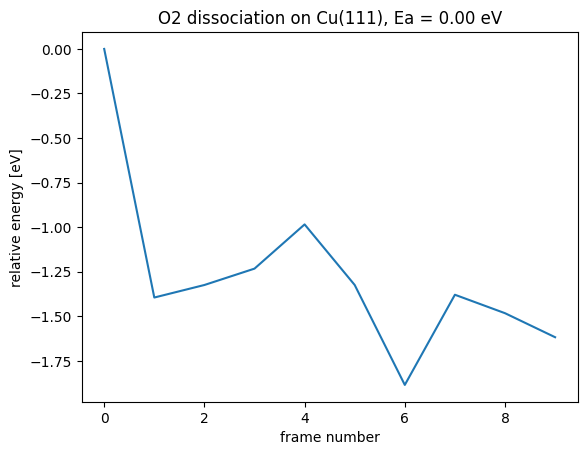

In [40]:
# Plot the reaction coordinate
es = [e - es[0] for e in es]
print(es)
plt.plot(es)
plt.xlabel("frame number")
plt.ylabel("relative energy [eV]")
plt.title(f"O2 dissociation on Cu(111), Ea = {max(es):1.2f} eV")
plt.savefig("CH_dissoc_on_Ru_0001.png")

In [47]:
# Make an interative html file of the optimized neb trajectory
x3d = X3D(optimized_neb)
x3d.write("optimized_neb_ch_disoc_on_Ru0001.html")